# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
os.environ.get("CONDA_PREFIX")

'/home/moeyensj/software/anaconda3/envs/py36'

In [3]:
import thor

In [4]:
DATABASE = "/mnt/data/solarsystem/msst/msst_survey.db"
con = sql.connect(DATABASE)

# Load Data

In [5]:
observationsNoNoise = pd.read_sql("""SELECT * FROM observations WHERE night < 59755""", con)
print(len(observationsNoNoise))
observationsNoNoise.drop_duplicates(subset=["designation", "exp_mjd"], inplace=True)
print(len(observationsNoNoise))
noise = pd.read_sql("""SELECT * FROM noise_100 WHERE night < 59755""", con)
noise["obsId"] = np.arange(observationsNoNoise["obsId"].values[-1] + 1, observationsNoNoise["obsId"].values[-1] + 1 + len(noise))

2527774
2525712


In [6]:
observations = pd.concat([observationsNoNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observationsNoNoise
del noise

In [7]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [8]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset=["designation"], inplace=True)

In [9]:
neos = orbits[orbits["a_au"] <= 1.3]["designation"].values

(140, 200)

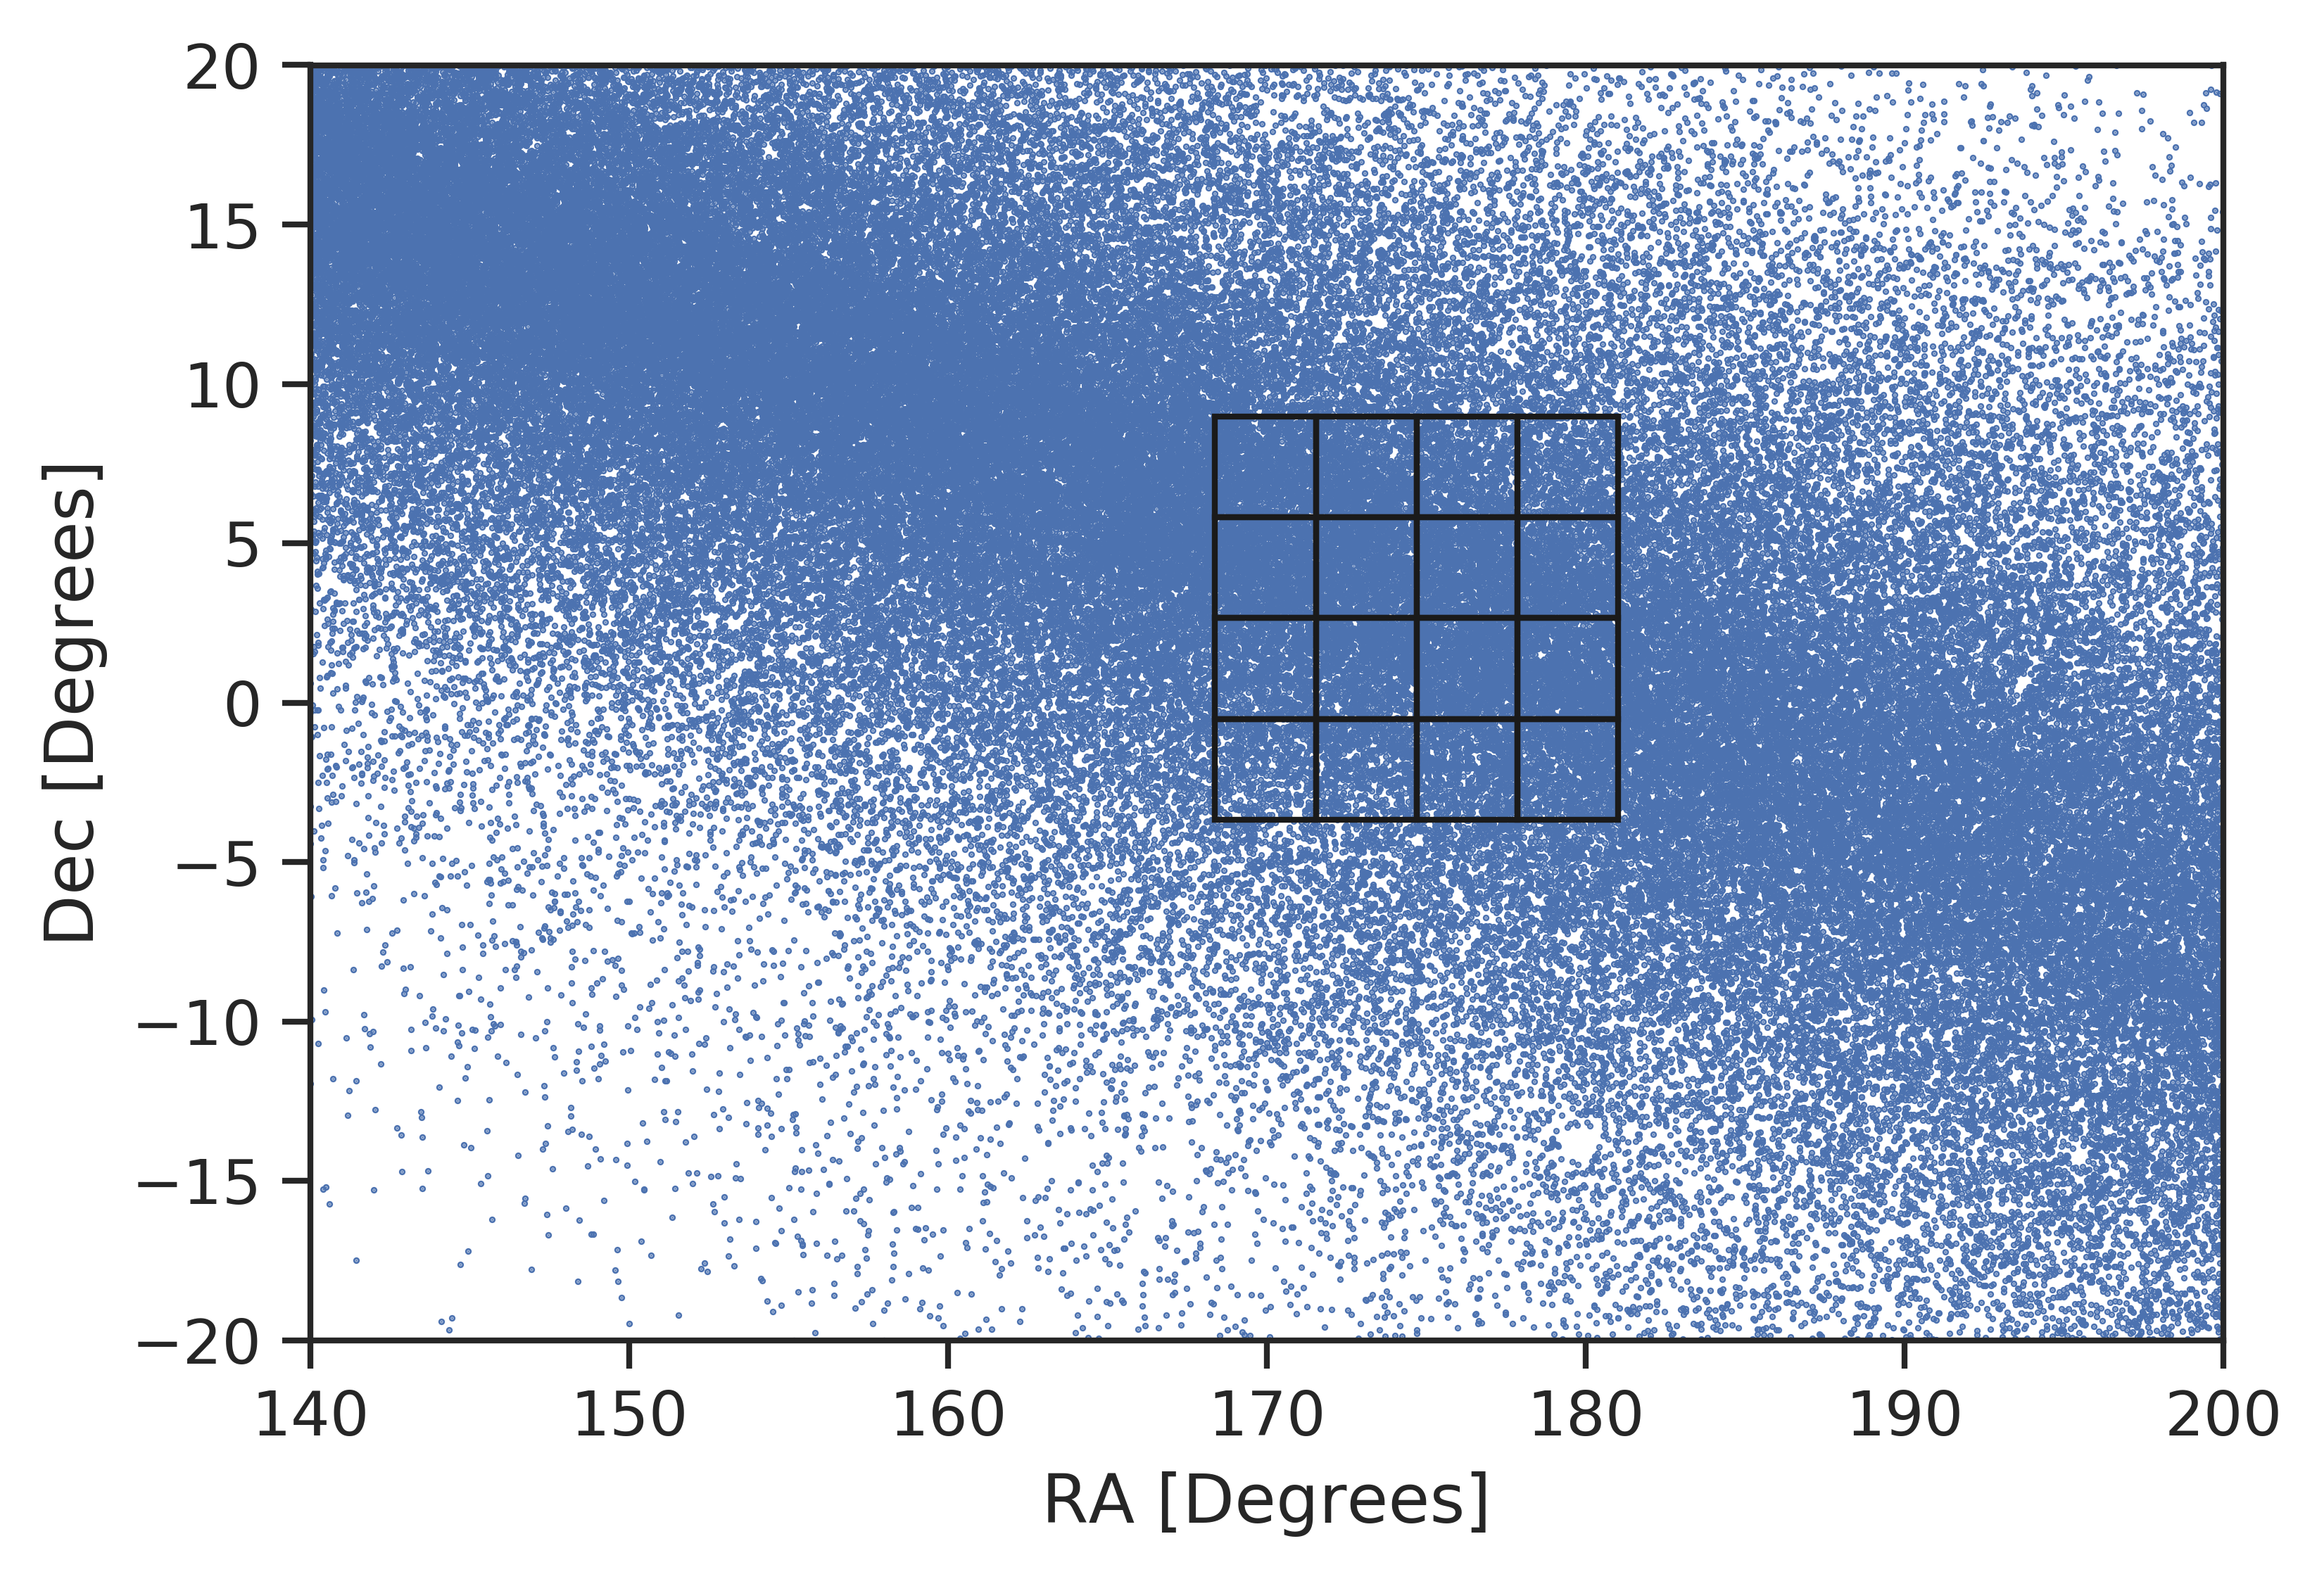

In [10]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=600)
ax.set_xlabel("RA [Degrees]")
ax.set_ylabel("Dec [Degrees]")
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2, yy-yField/2), xField, yField, fill=False, lw=1, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["Dec_deg"].values,
           s=0.1,
           c="b")
ax.set_aspect("equal")
ax.set_ylim(-20, 20)
ax.set_xlim(140, 200)

## Make Reduced Survey

In [11]:
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
observations = observations[observations["fieldId"].isin(fields)]
#observations.to_csv("../analysis/msst_4x4/observations.txt", sep=" ", index=False)

In [12]:
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset="designation", inplace=True)
#orbits.to_csv("../analysis/msst_4x4/orbits.txt", sep=" ", index=False)

(5.642774417833482, 9.132279844018699)

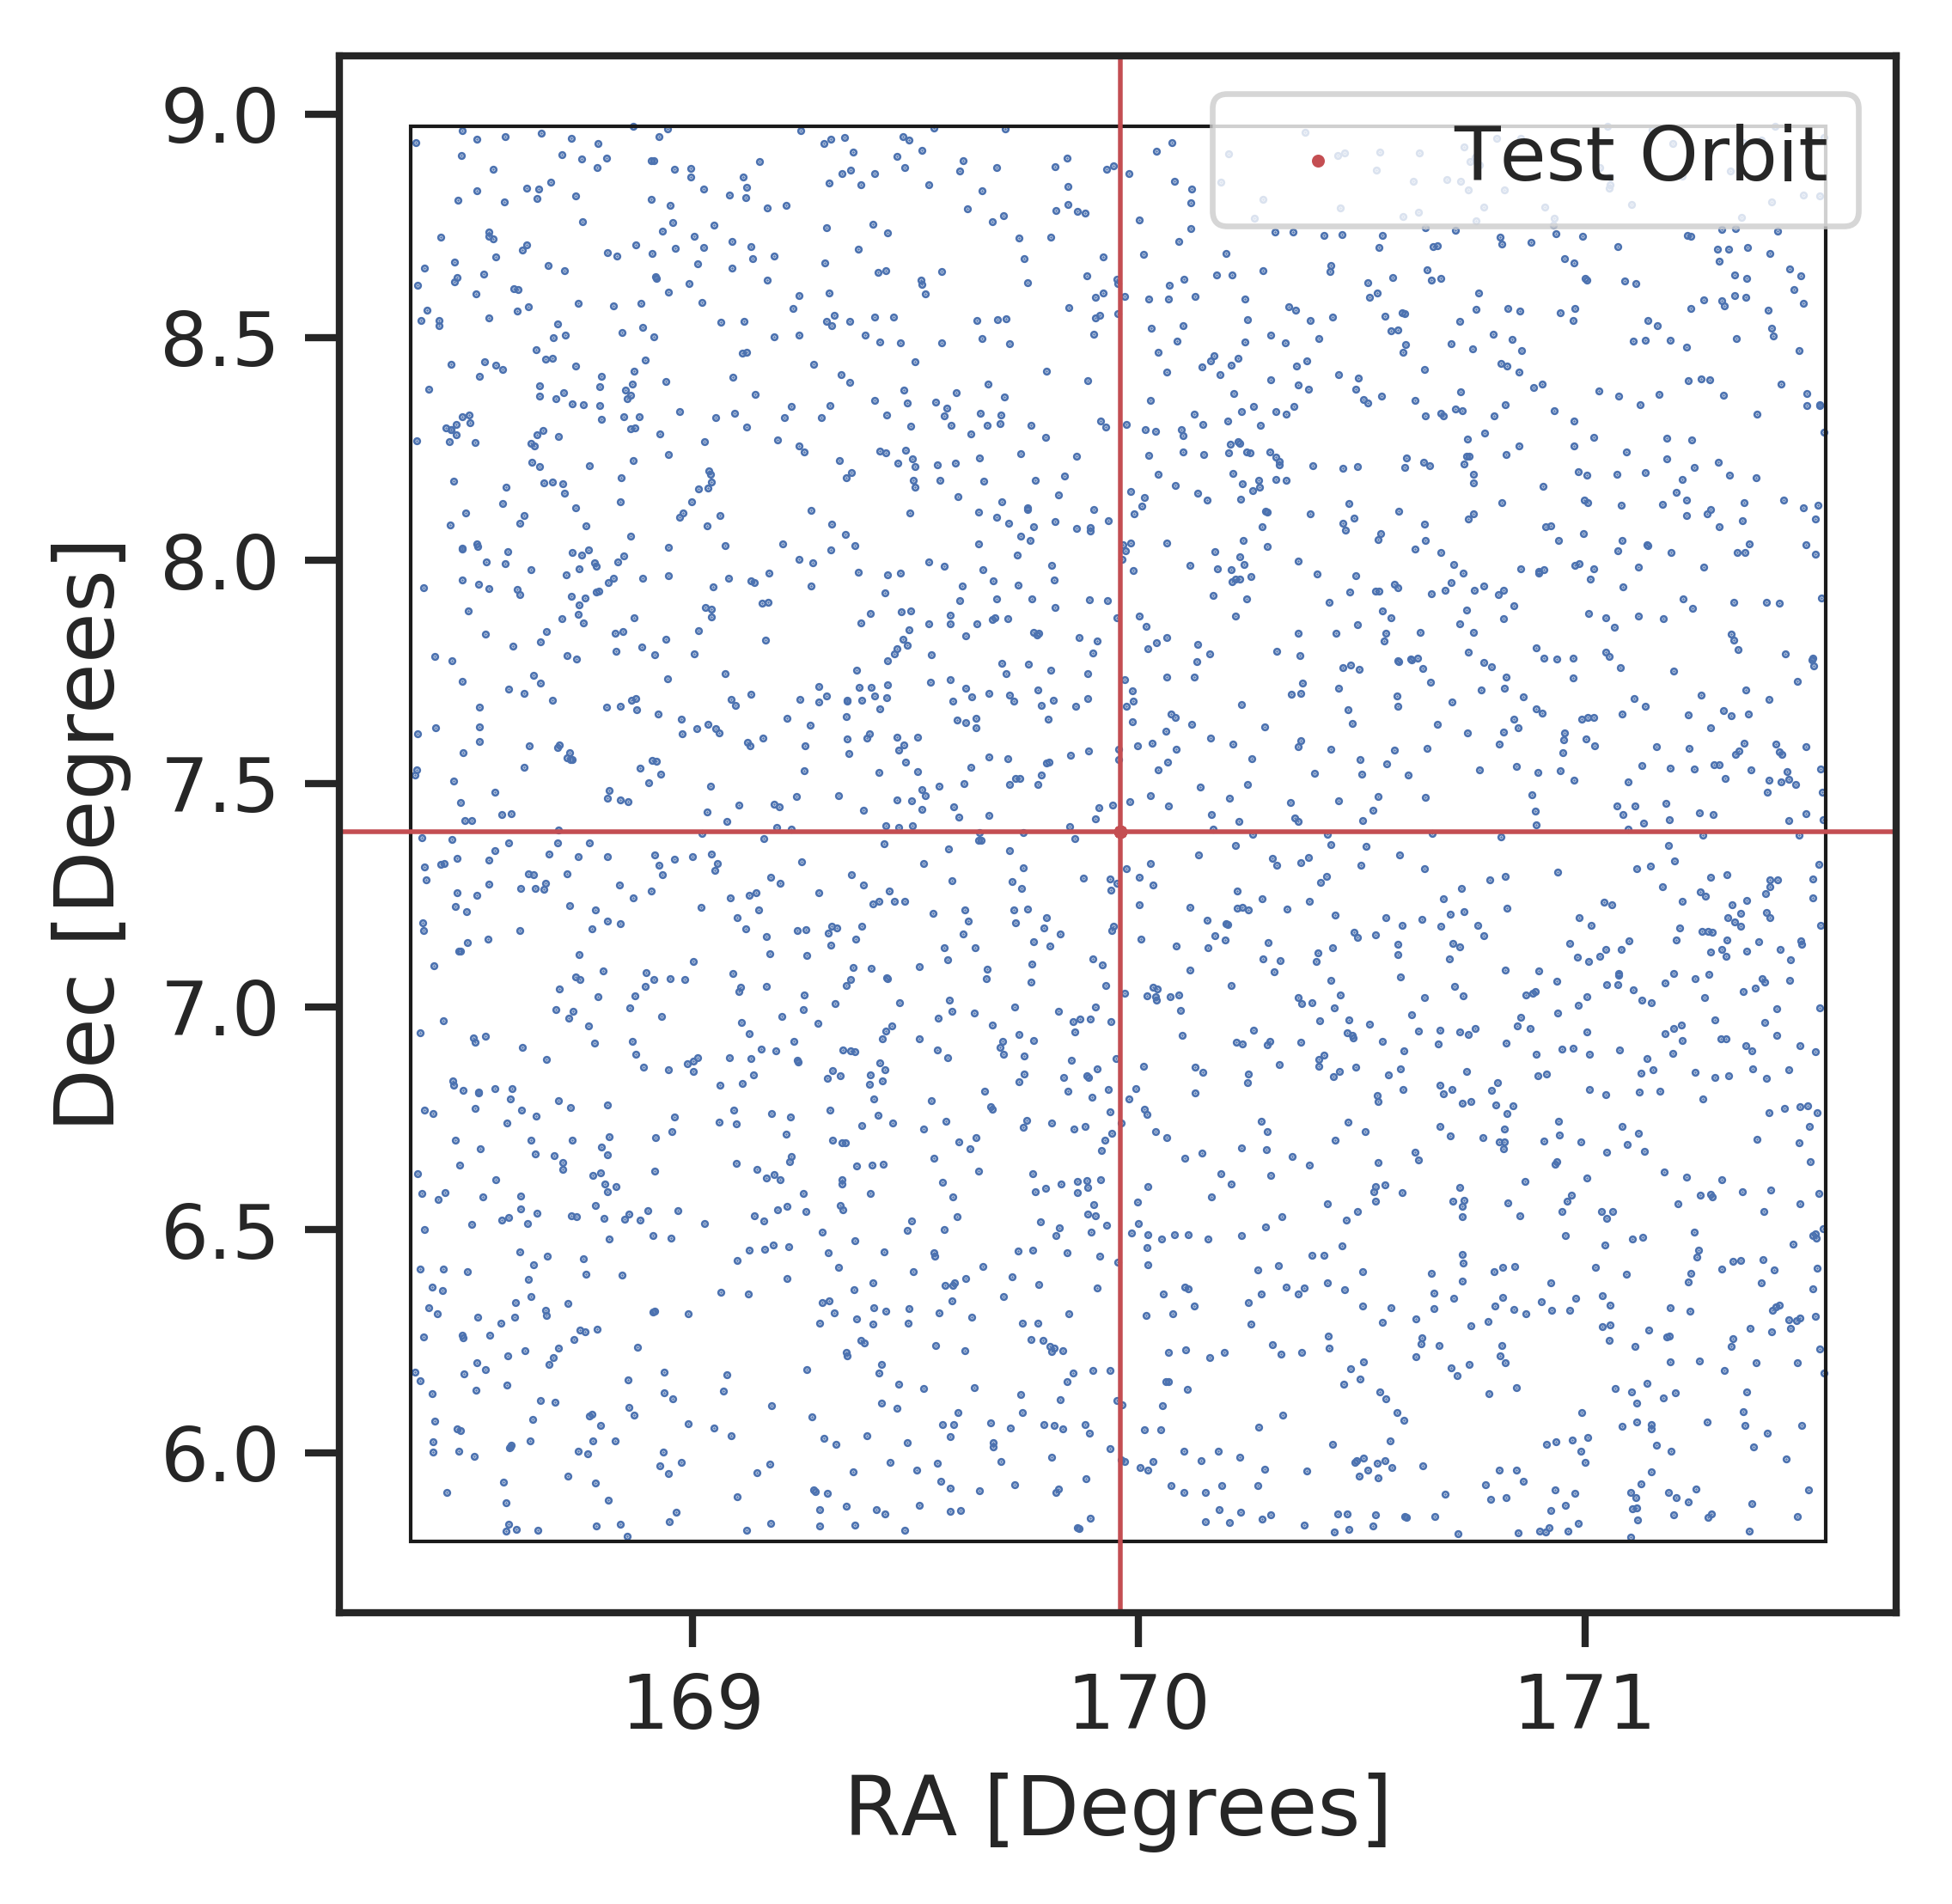

In [13]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=600)
ax.set_xlabel("RA [Degrees]")
ax.set_ylabel("Dec [Degrees]")
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin([405]))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin([405]))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2- 0.01, yy-yField/2 -0.01), xField+0.01, yField+0.01, fill=False, lw=0.5, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["fieldId"].isin([405]))]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["fieldId"].isin([405]))]["Dec_deg"].values,
           s=0.1,
           c="b")
ax.scatter(survey[survey["fieldId"].isin([405])]["fieldRA_deg"].values, survey[survey["fieldId"].isin([405])]["fieldDec_deg"].values, s=1, c="r", 
           label="Test Orbit")
ax.legend()
ax.set_aspect("equal")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(survey[survey["fieldId"].isin([405])]["fieldDec_deg"].values, *xlim, lw=0.5, color="r")
ax.vlines(survey[survey["fieldId"].isin([405])]["fieldRA_deg"].values, *ylim, lw=0.5, color="r")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [14]:
average_orbits = thor.findAverageOrbits(observations[(observations["night"] == 59740)], rValues=[0.0, 2.5, 5.0, 10.0])

THOR: findAverageObject
-------------------------
Finding average orbit in 3 heliocentric distance bins...
Done.
-------------------------



In [15]:
average_orbits

orbit_id      r_au  HEclObj_dX/dt_au_p_day  HEclObj_dY/dt_au_p_day  \
0         1  2.314816                0.004529               -0.010996   
1         2  2.759569                0.002326               -0.009072   
2         3  5.143260                0.000385               -0.006312   

   HEclObj_dZ/dt_au_p_day       exp_mjd      RA_deg   Dec_deg designation  
0               -0.000038  59740.246528  176.340608  5.265090     K14J09X  
1               -0.000009  59740.247222  175.959376 -0.407342       b3451  
2                0.000082  59740.219444  168.999899  0.675941       m8613

THOR: runTHOR
-------------------------
Running THOR with 3 orbits...

THOR: analyzeObservations
-------------------------
Analyzing observations...
Known object observations: 160724
Unknown object observations: 0
False positive observations: 127468
Percent known object observations (%): 55.770
Percent unknown object observations (%): 0.000
Percent false positive observations (%): 44.230
Unique known objects: 25628
Unique known objects with at least 5 detections: 19234

Total time in seconds: 0.2794492244720459
-------------------------

THOR: runTHOR
-------------------------
Running orbit 1...

THOR: analyzeProjections
-------------------------
Analyzing projections...
Known object observations: 10656
Unknown object observations: 0
False positive observations: 7558
Percent known object observations (%): 58.504
Percent unknown object observations (%): 0.000
Percent false positive observations (%): 41.496
Unique known objects: 1943
Unique known objects with at least 5 detections: 1259


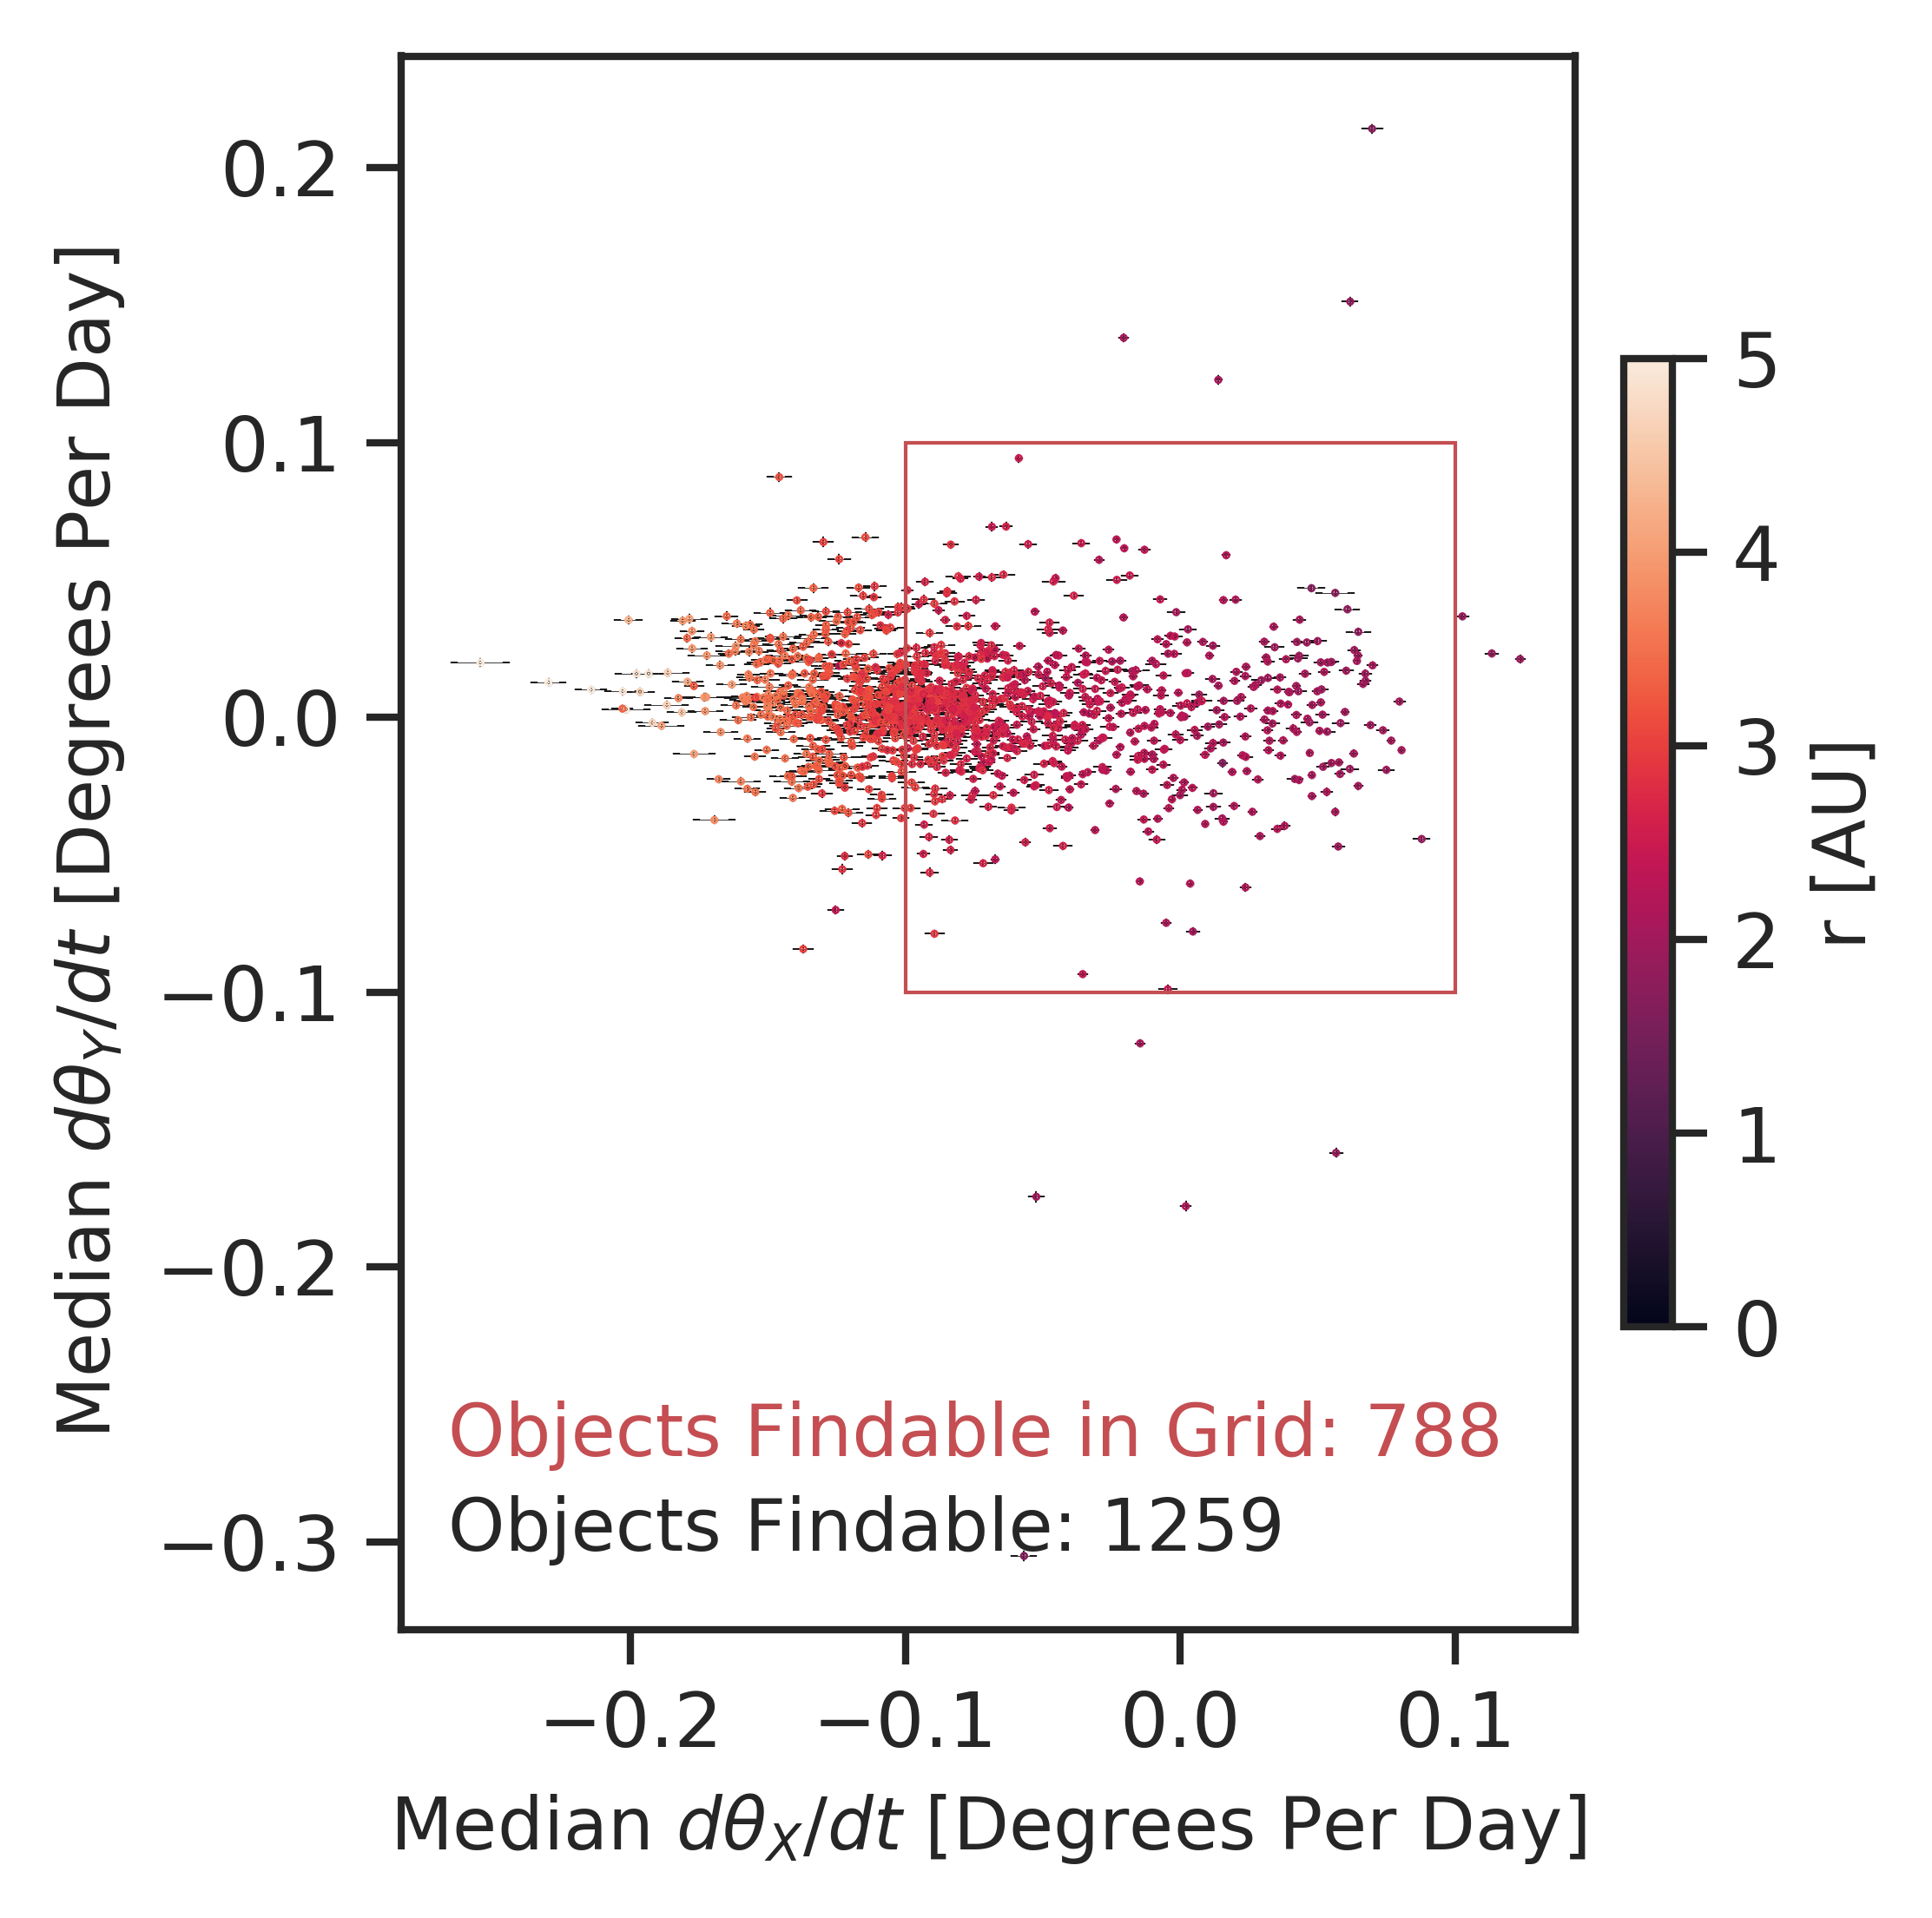

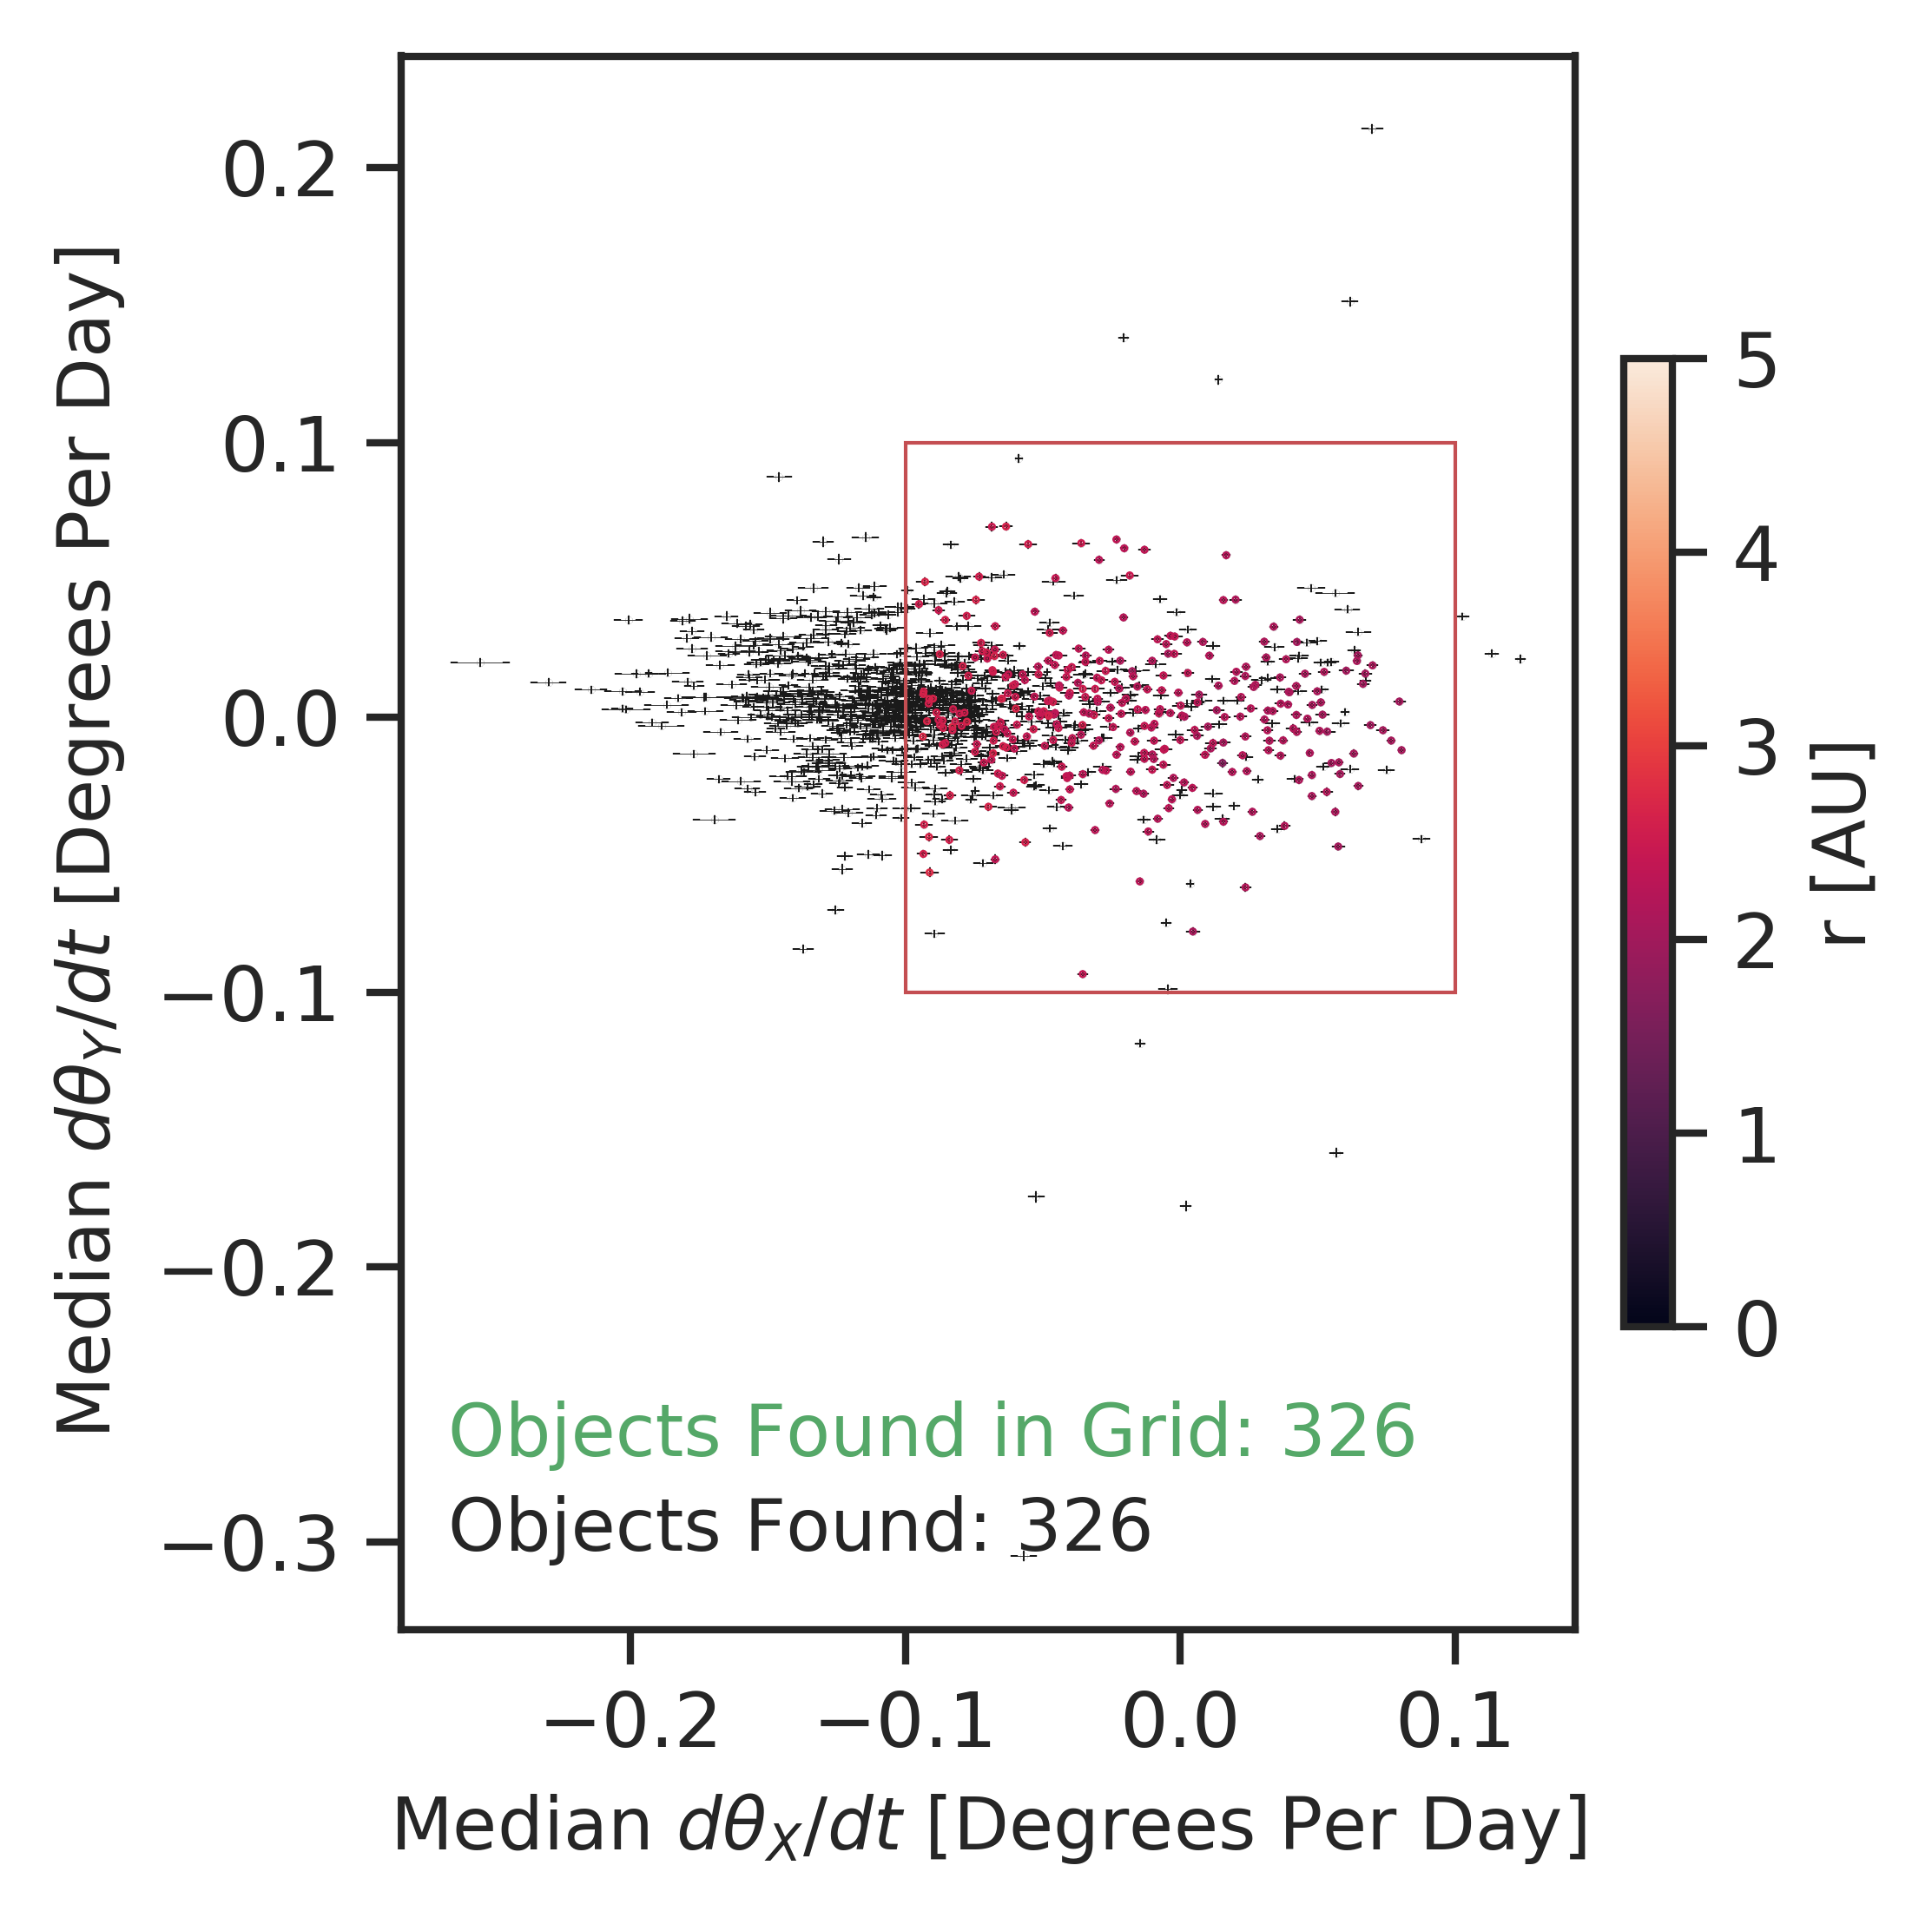

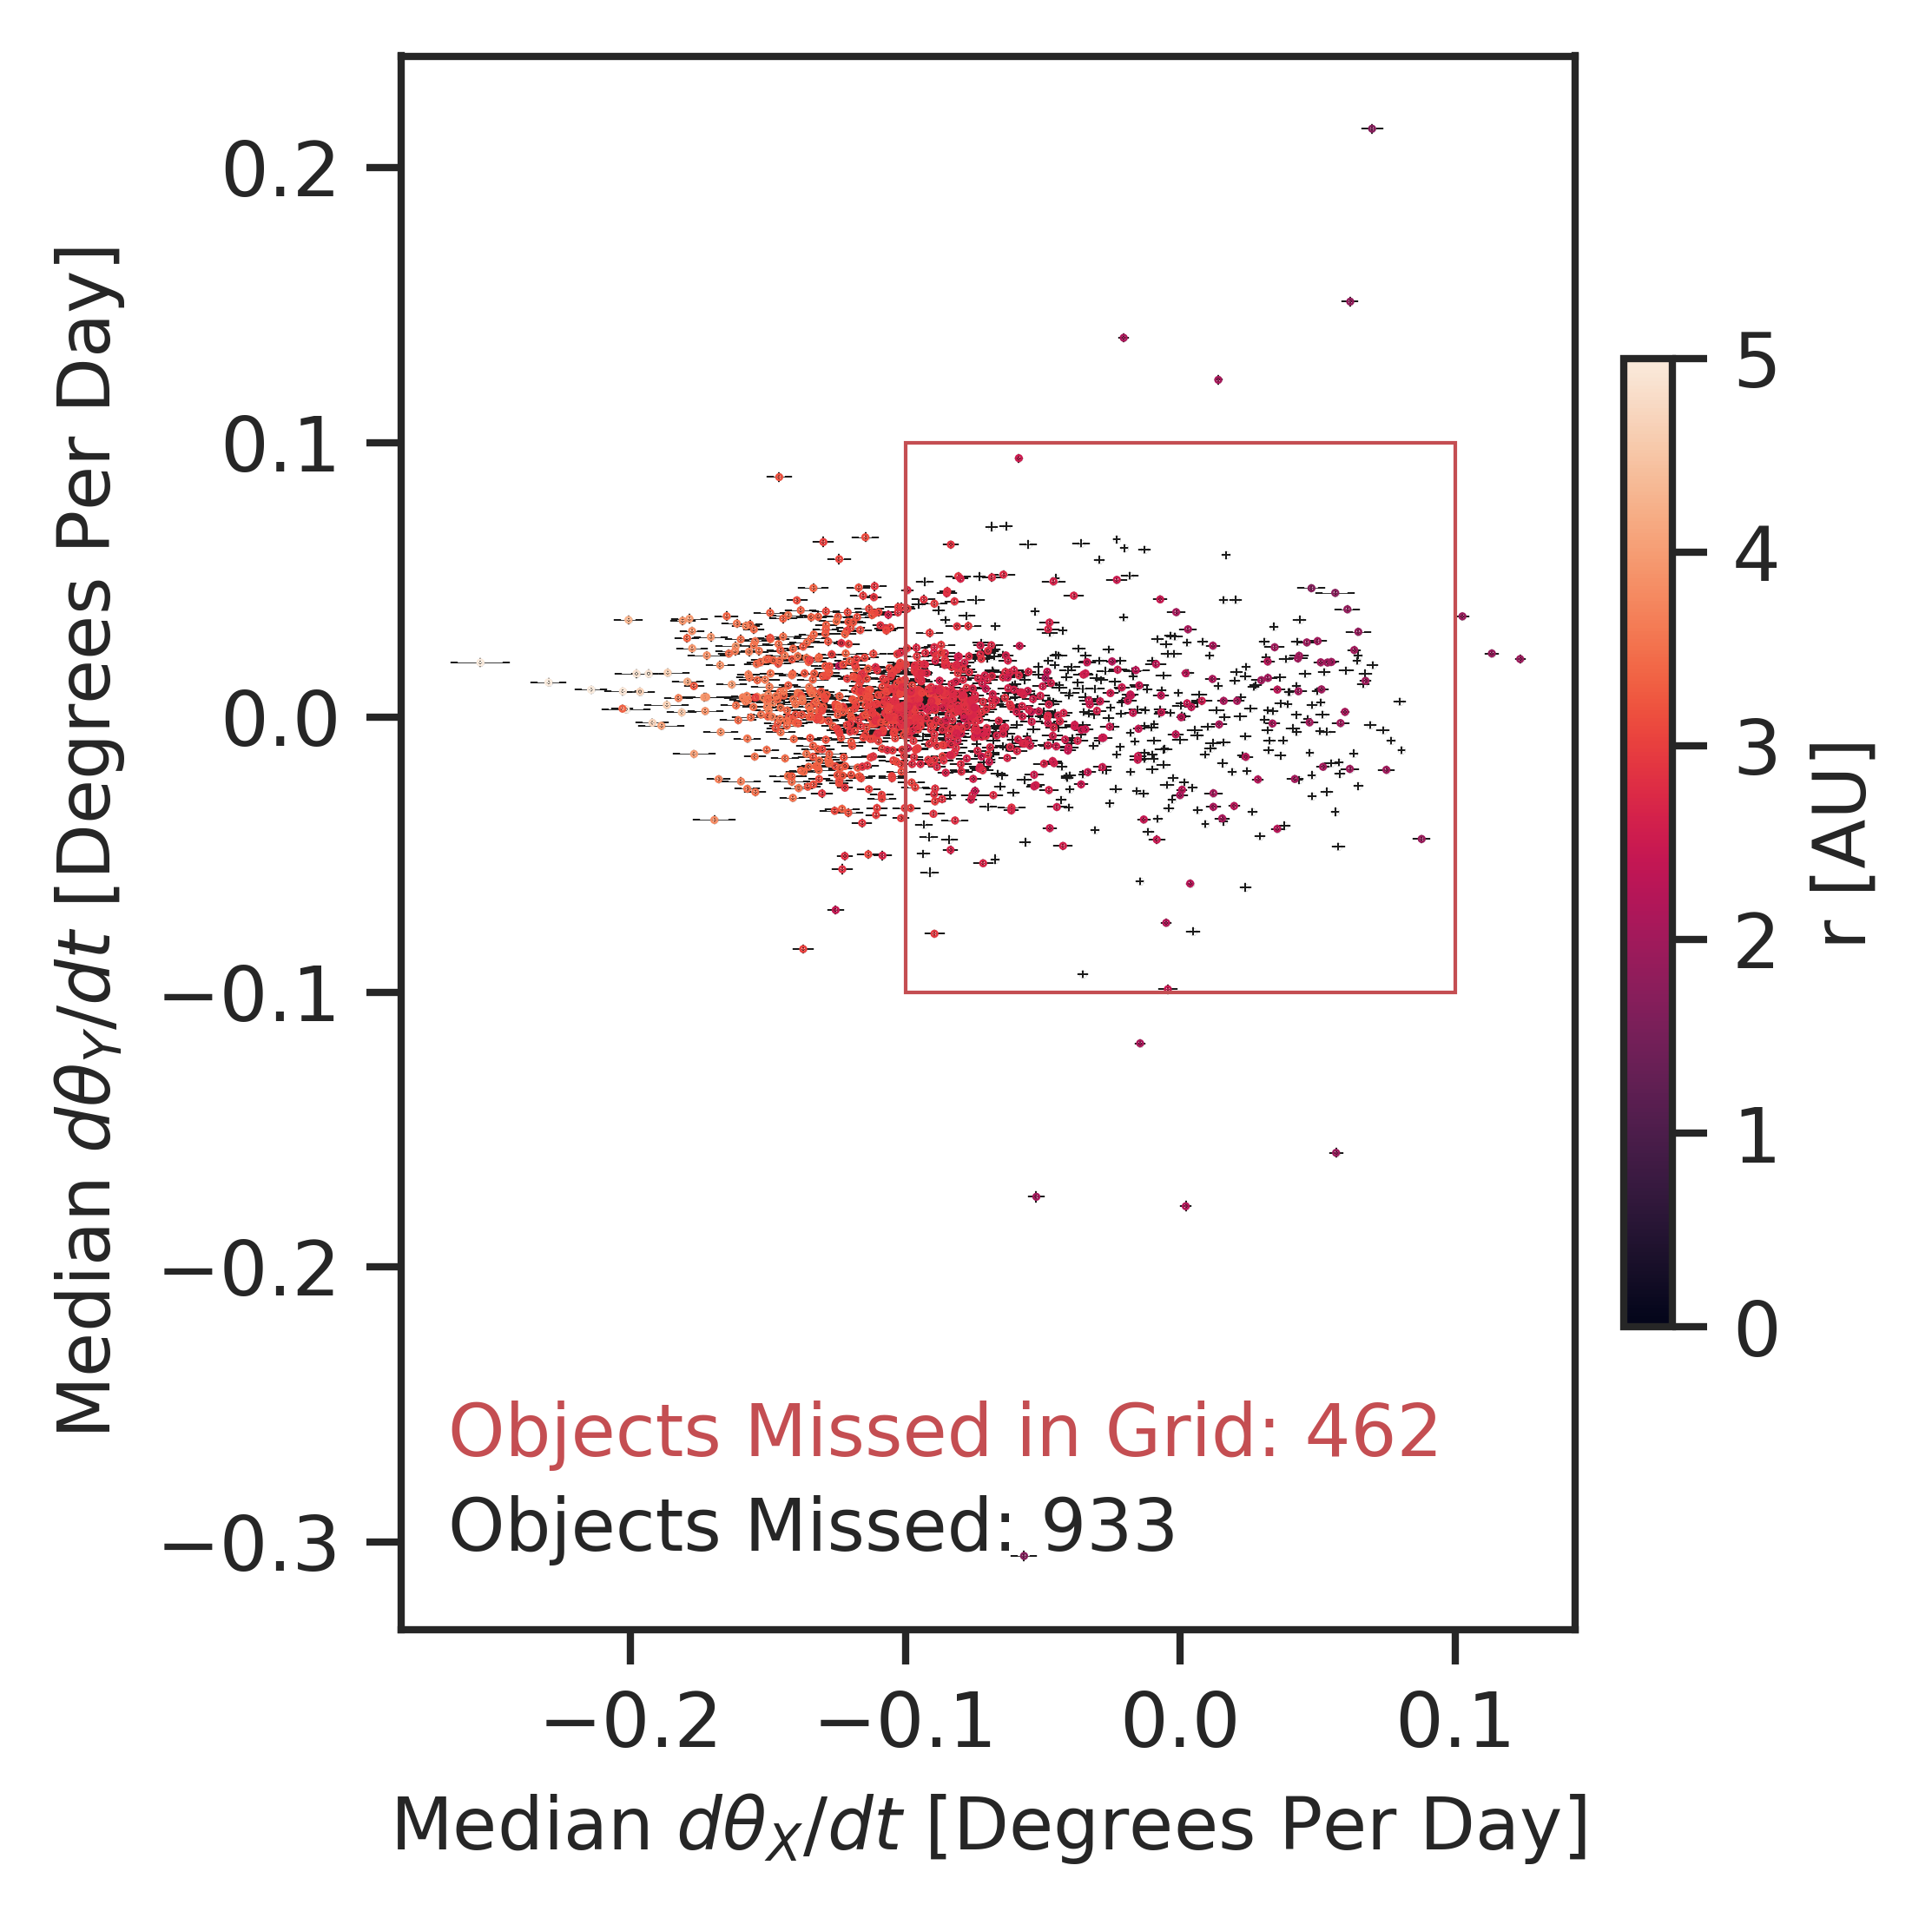

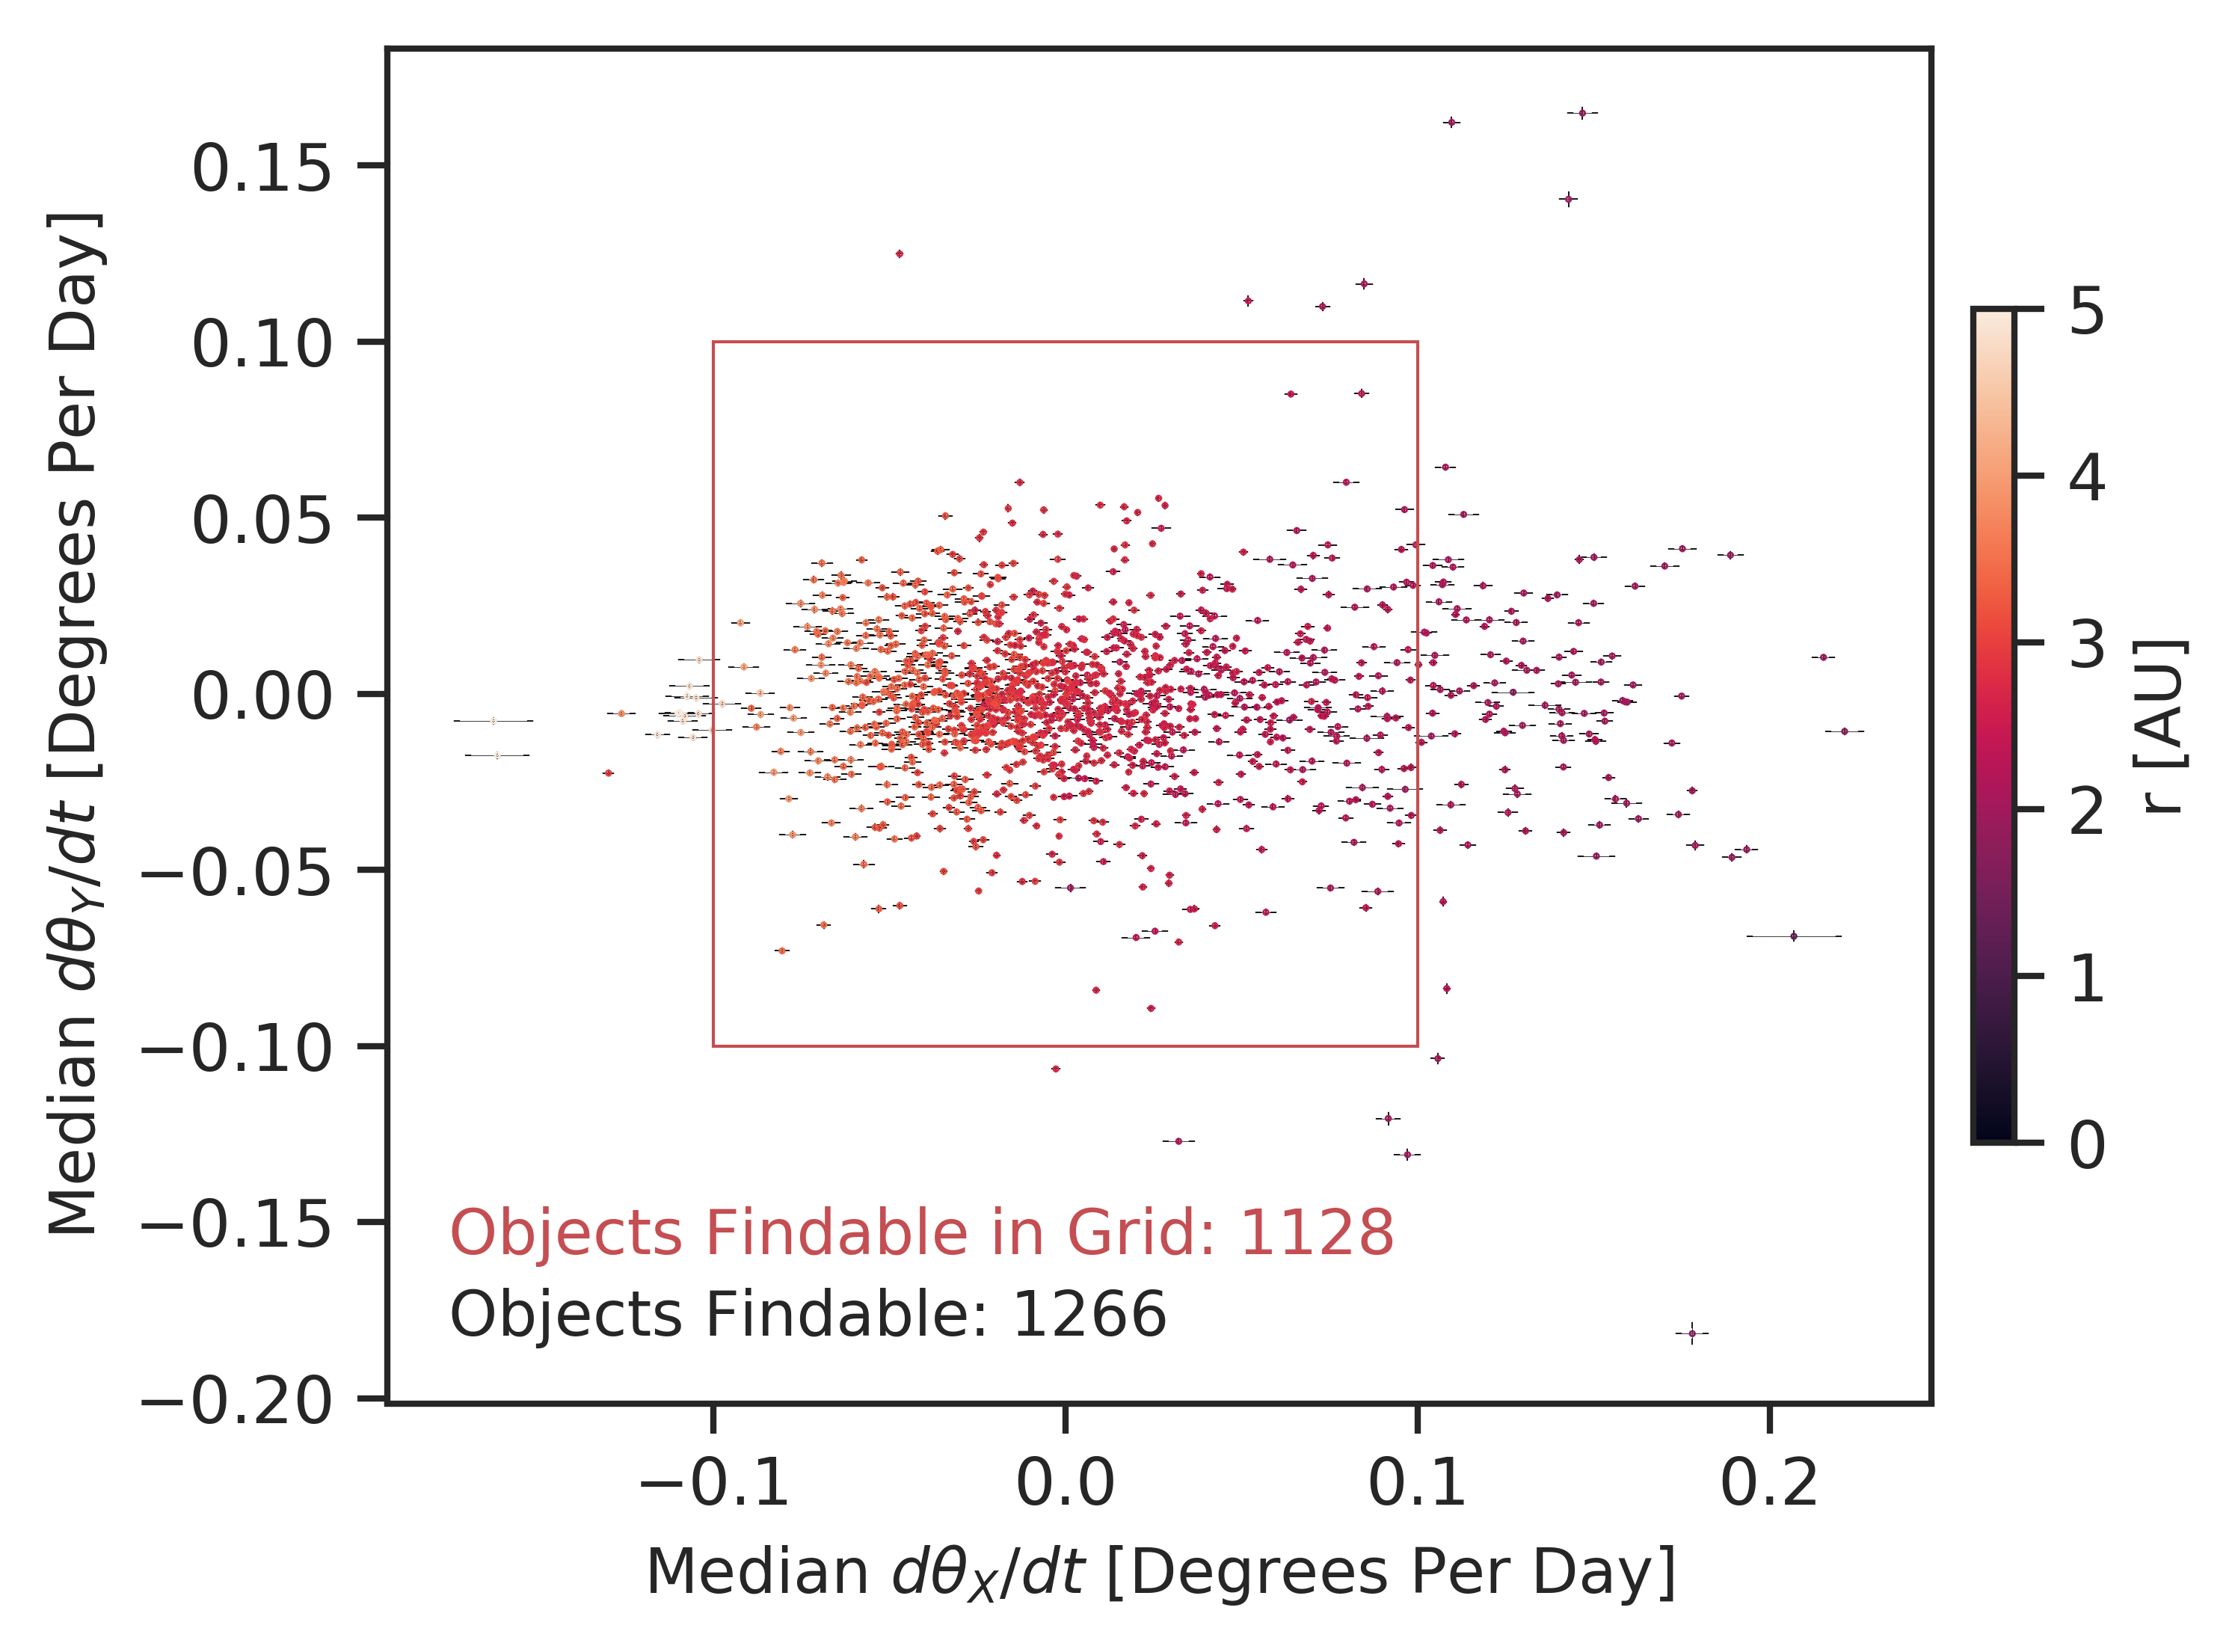

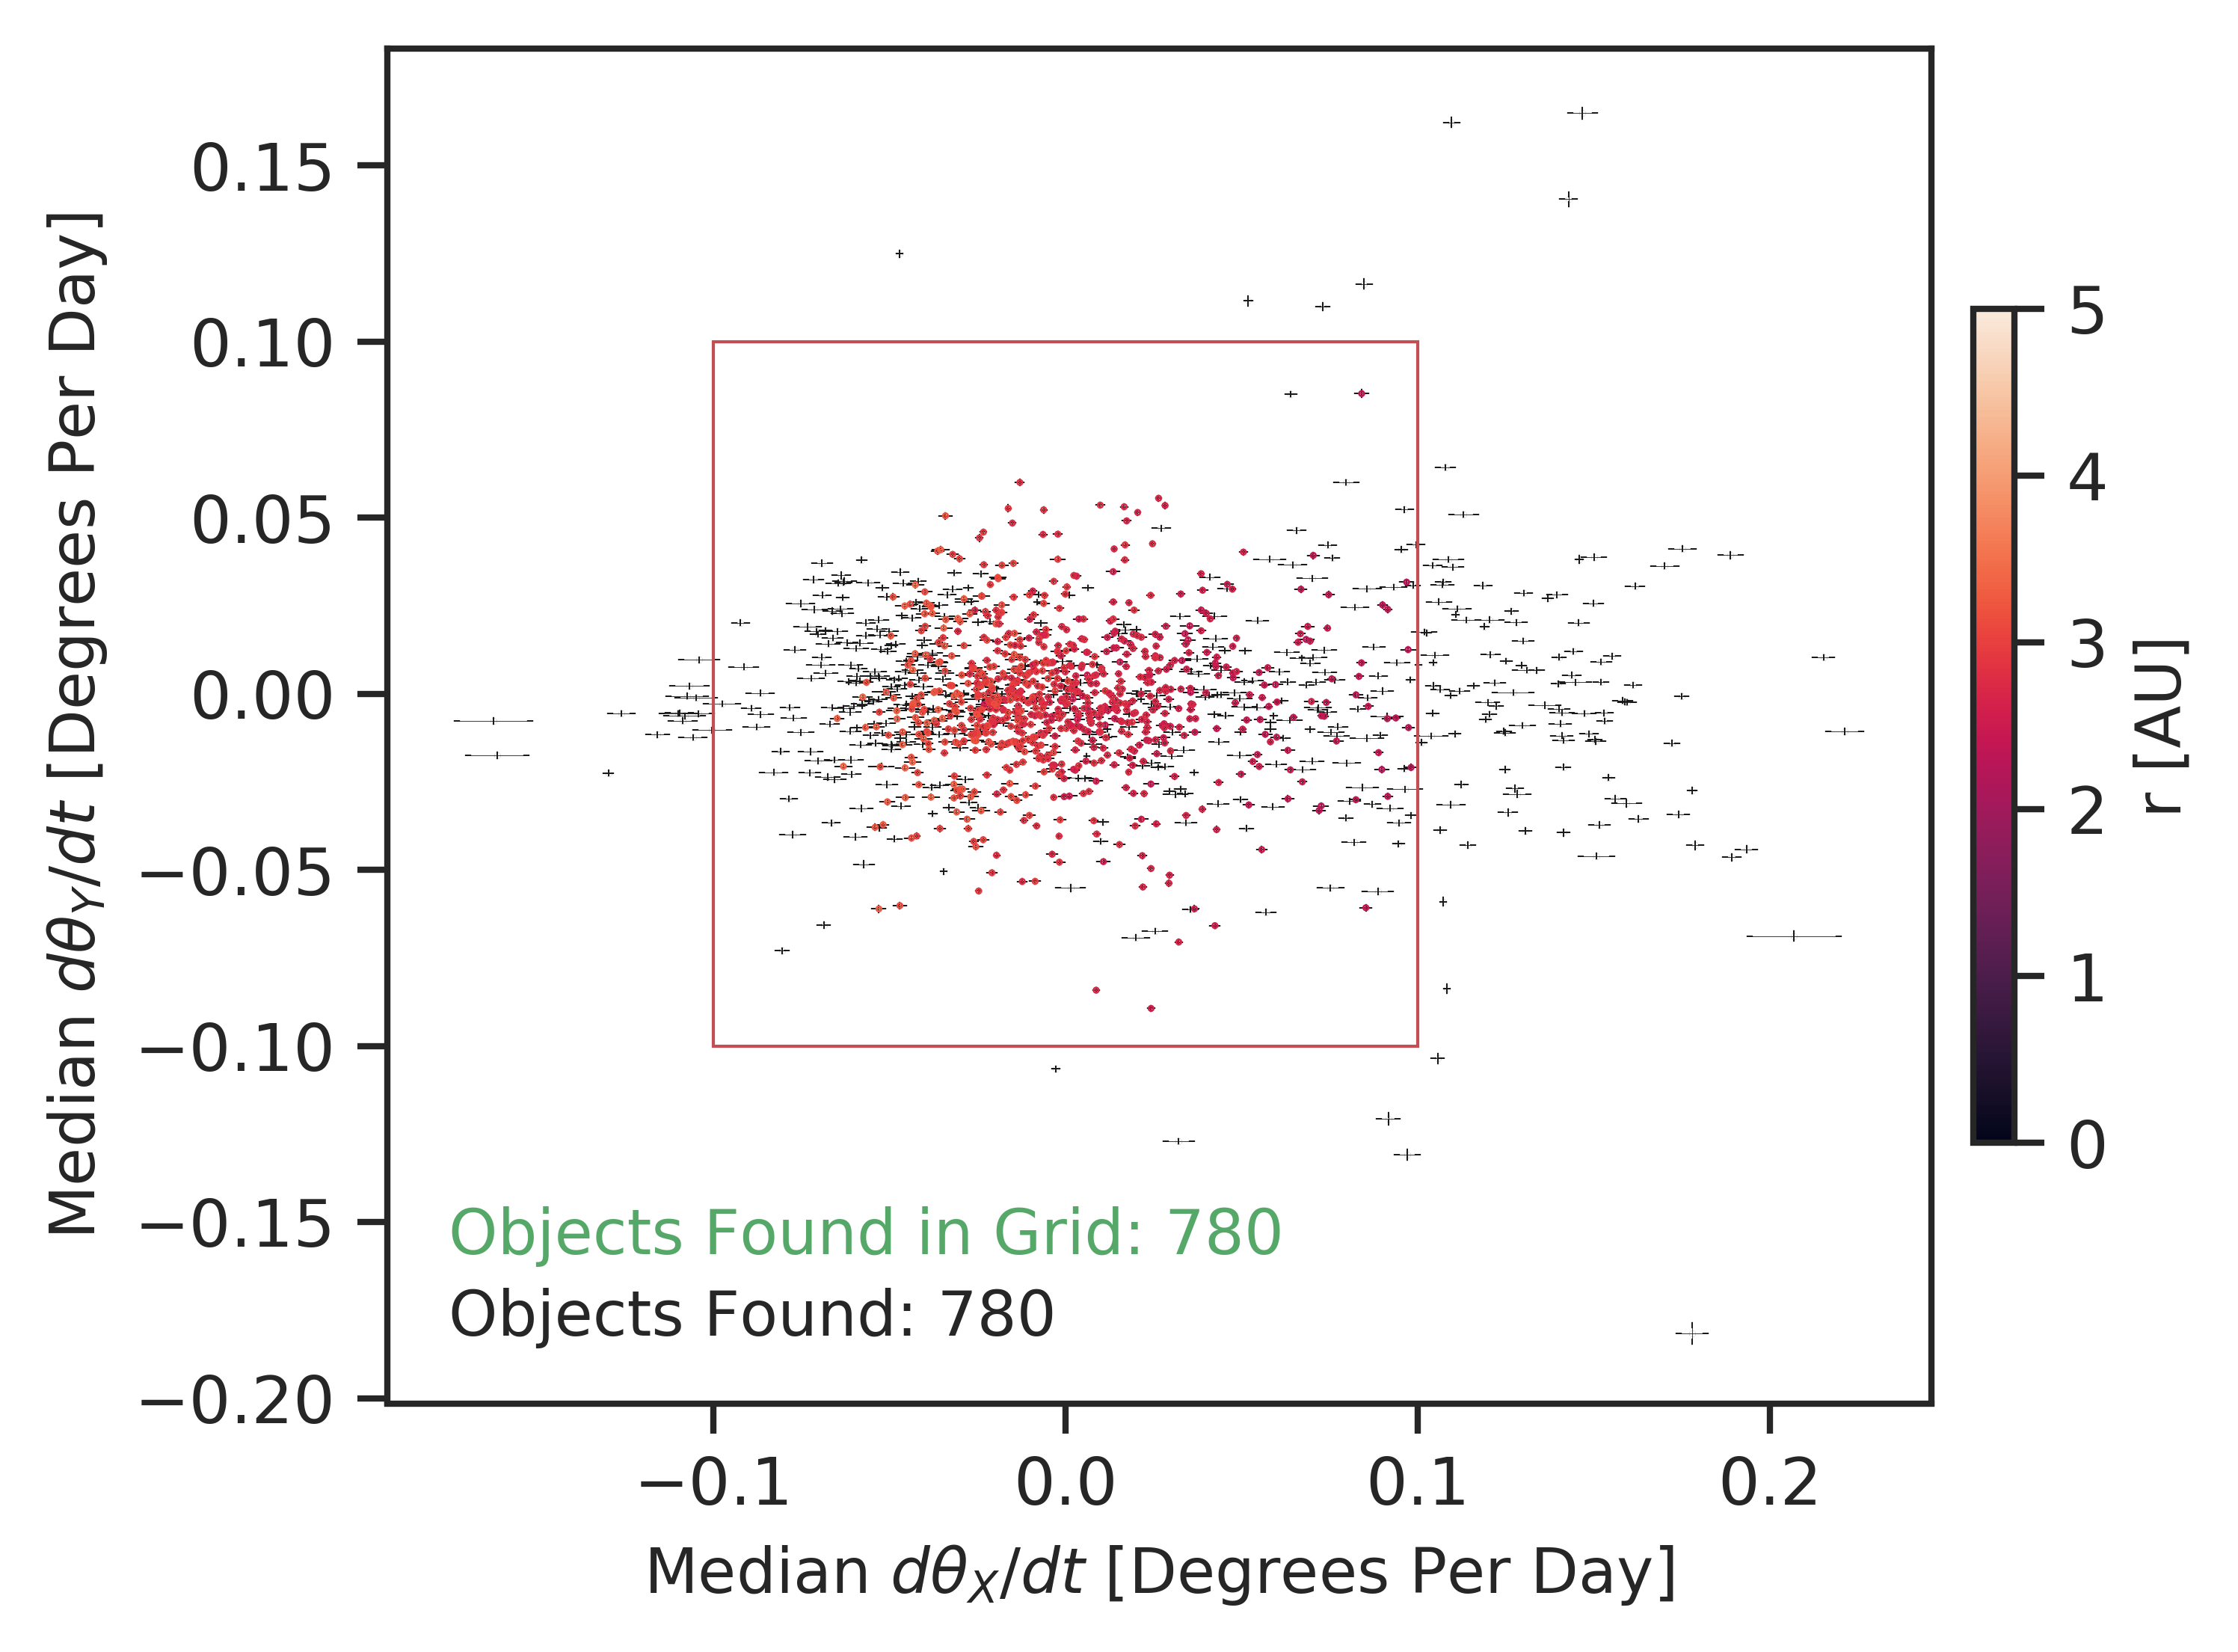

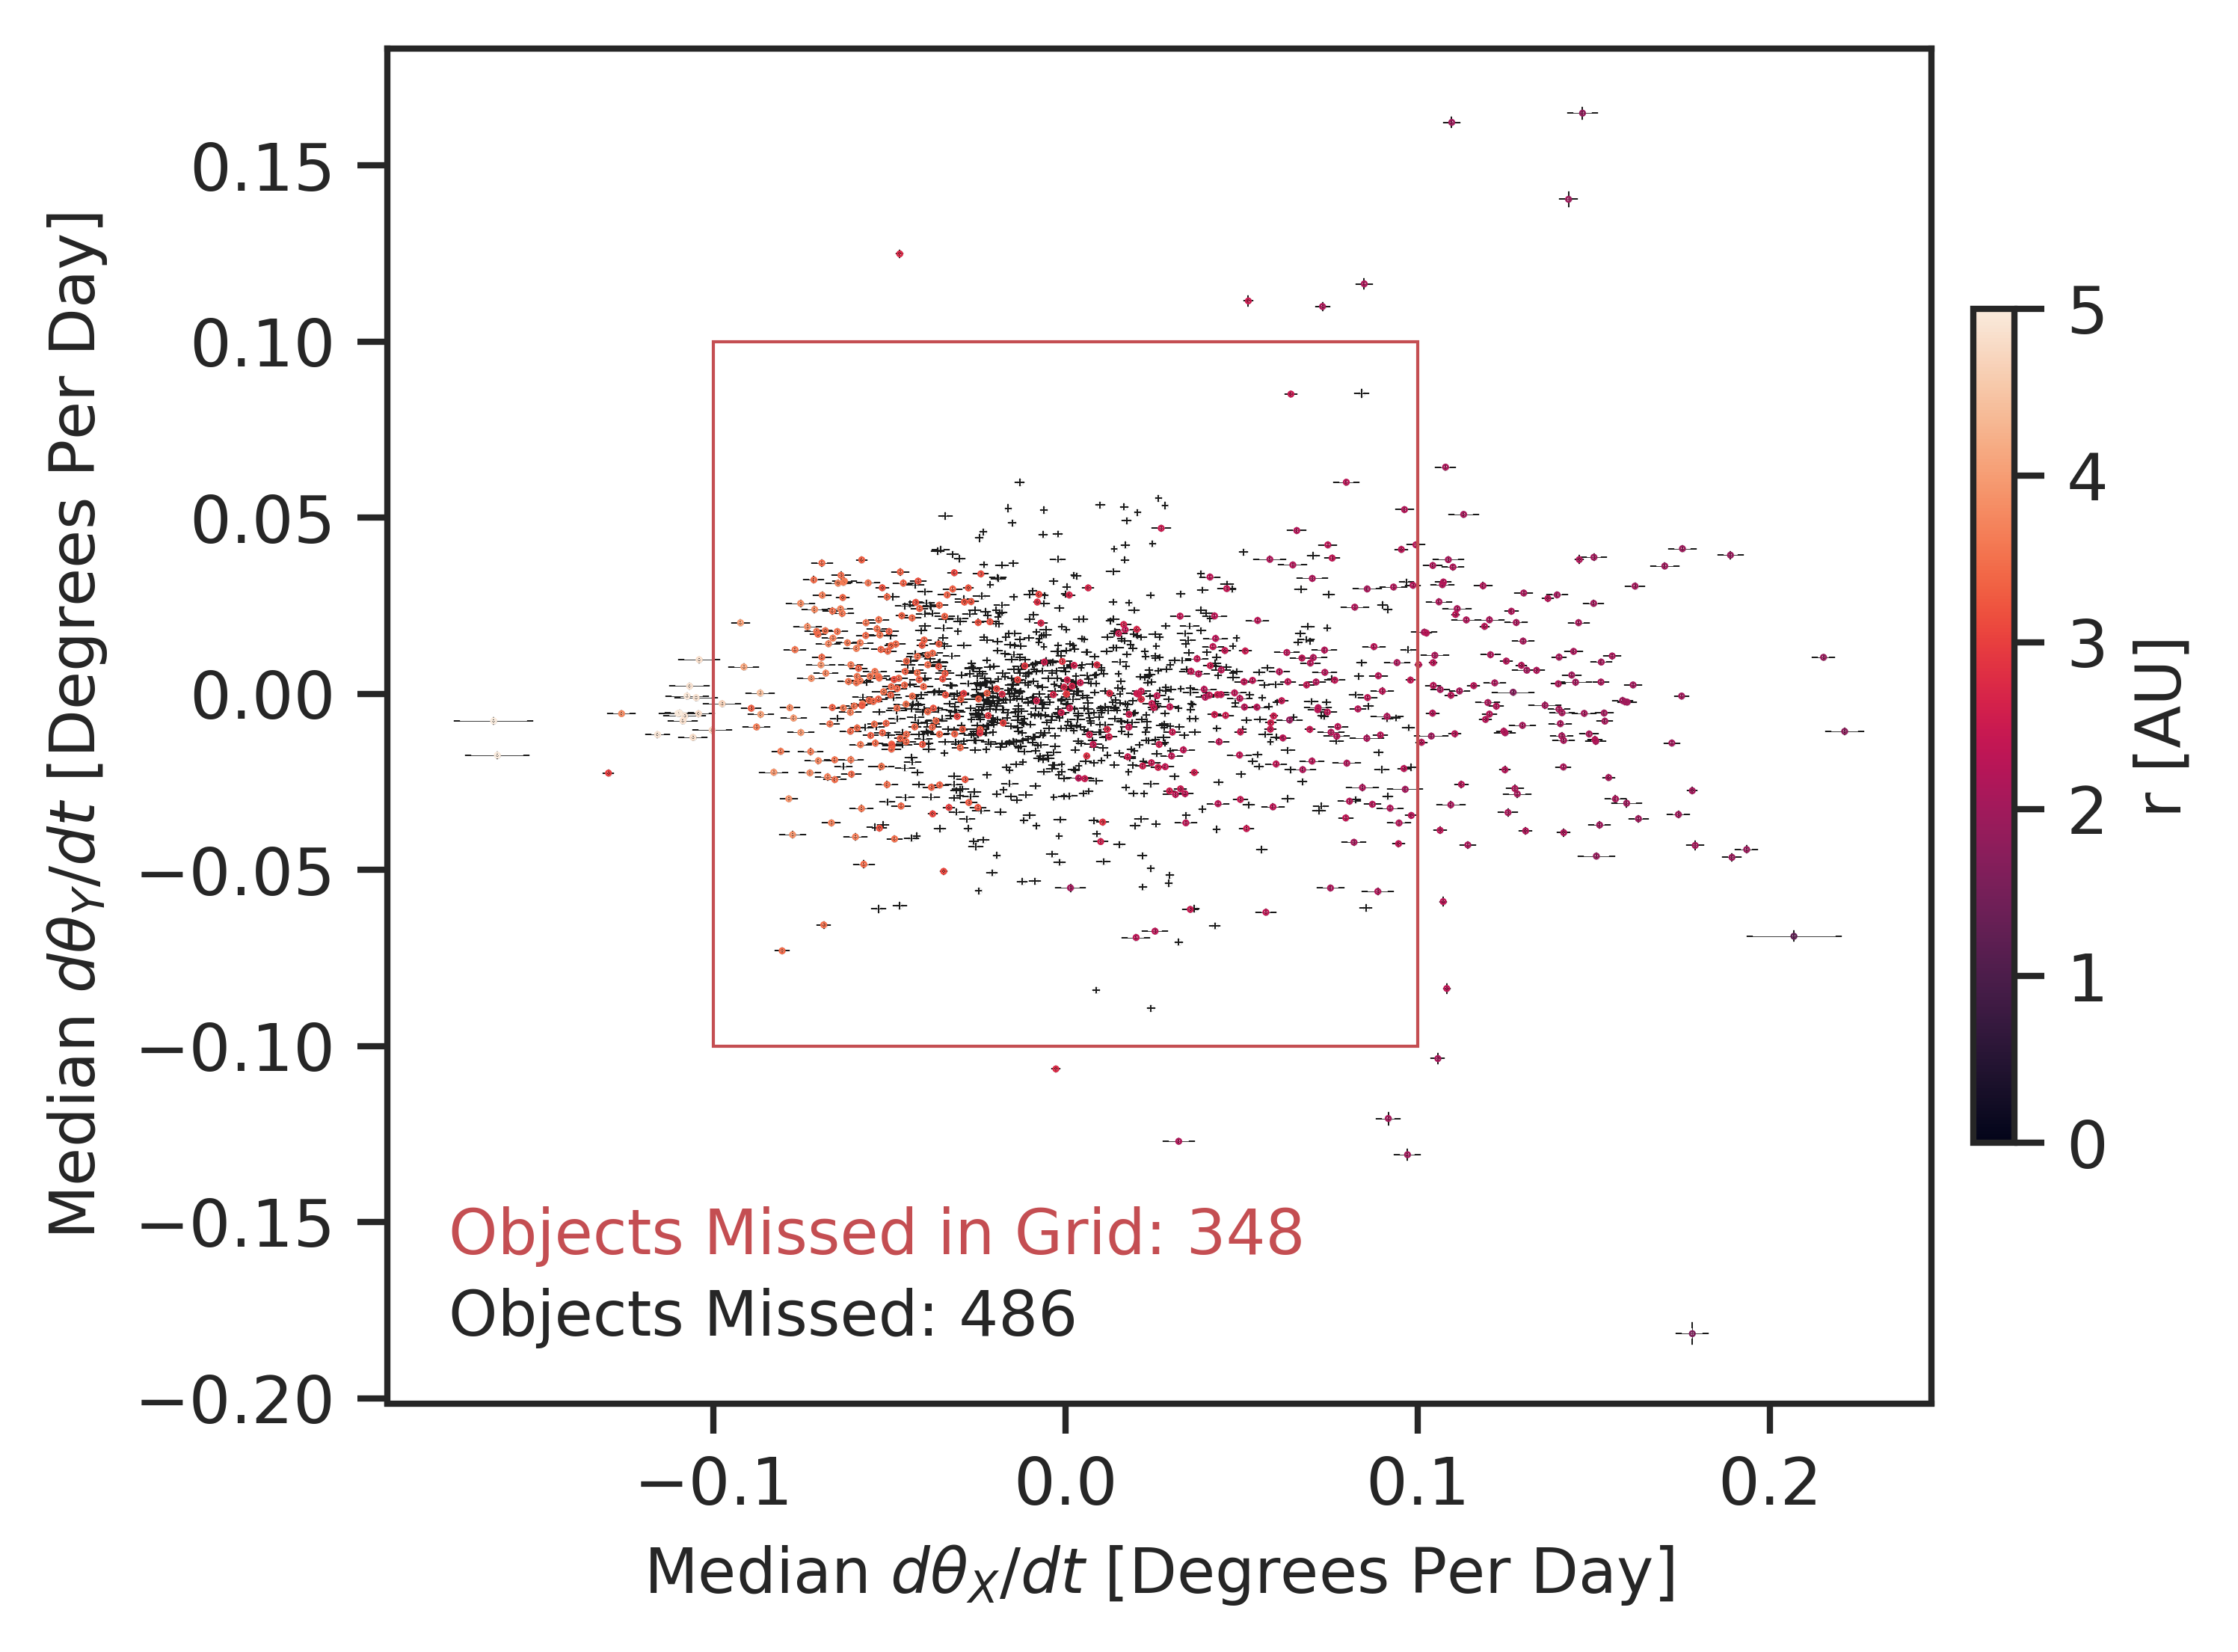

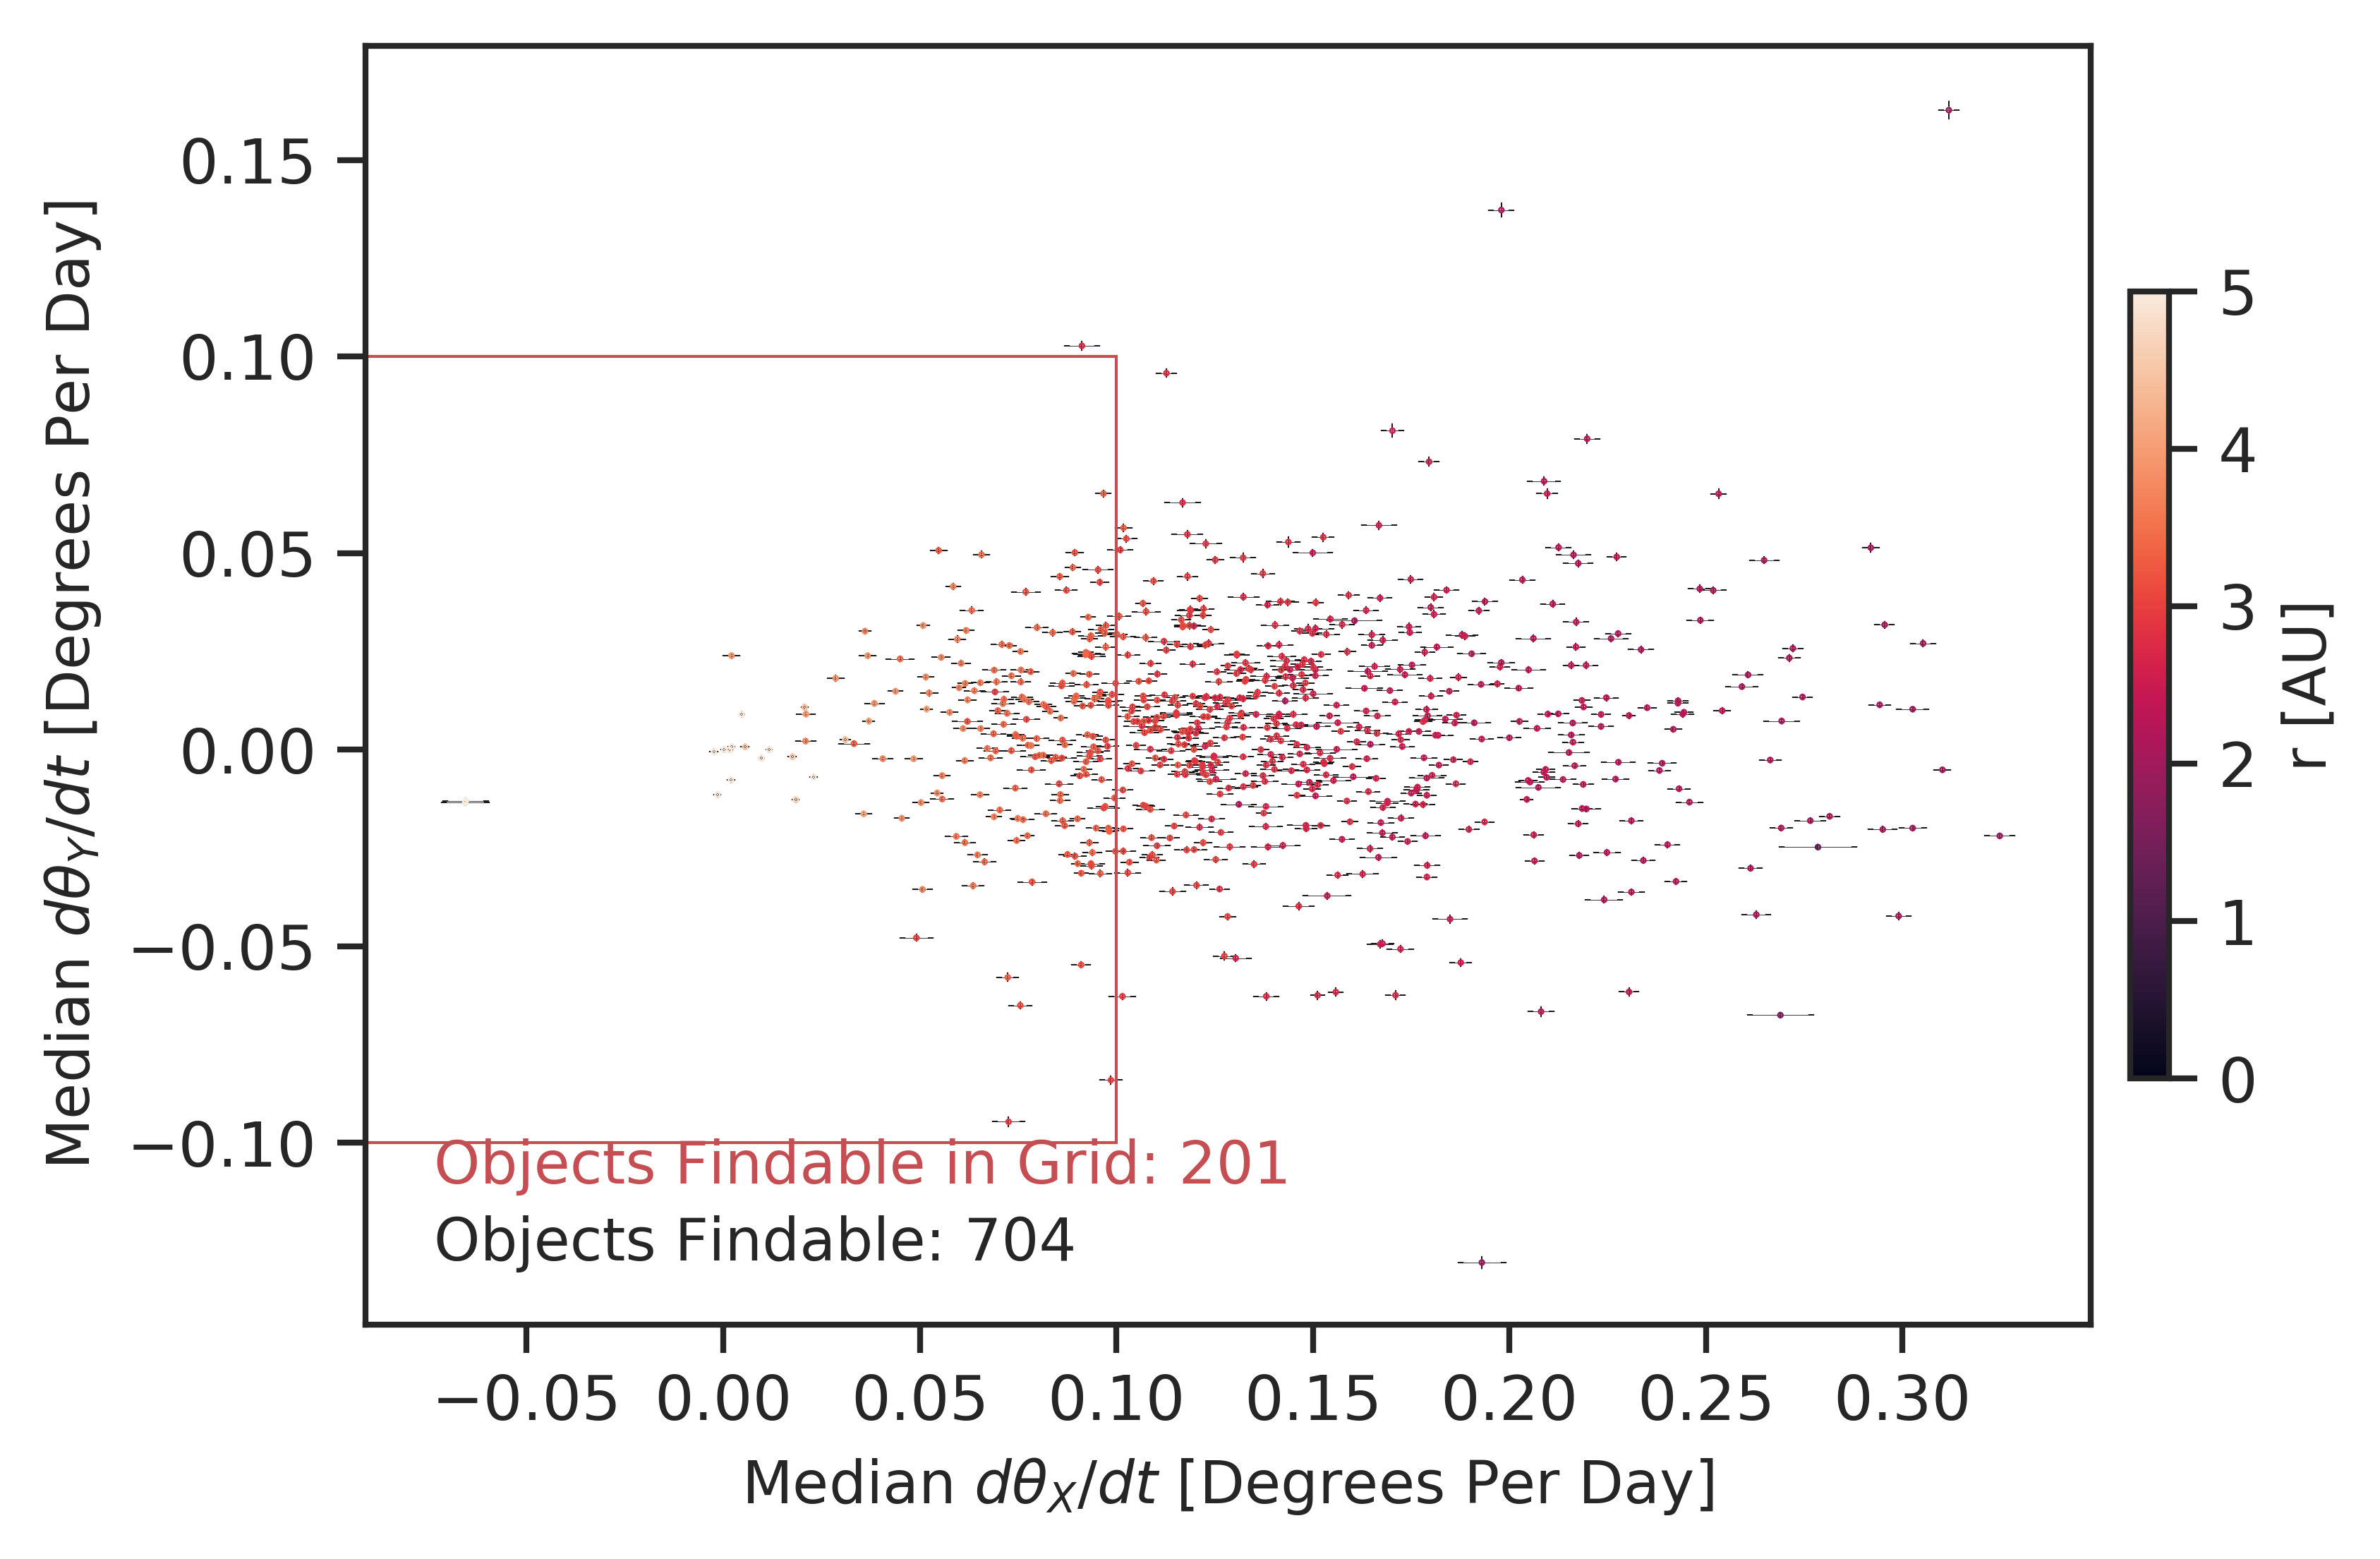

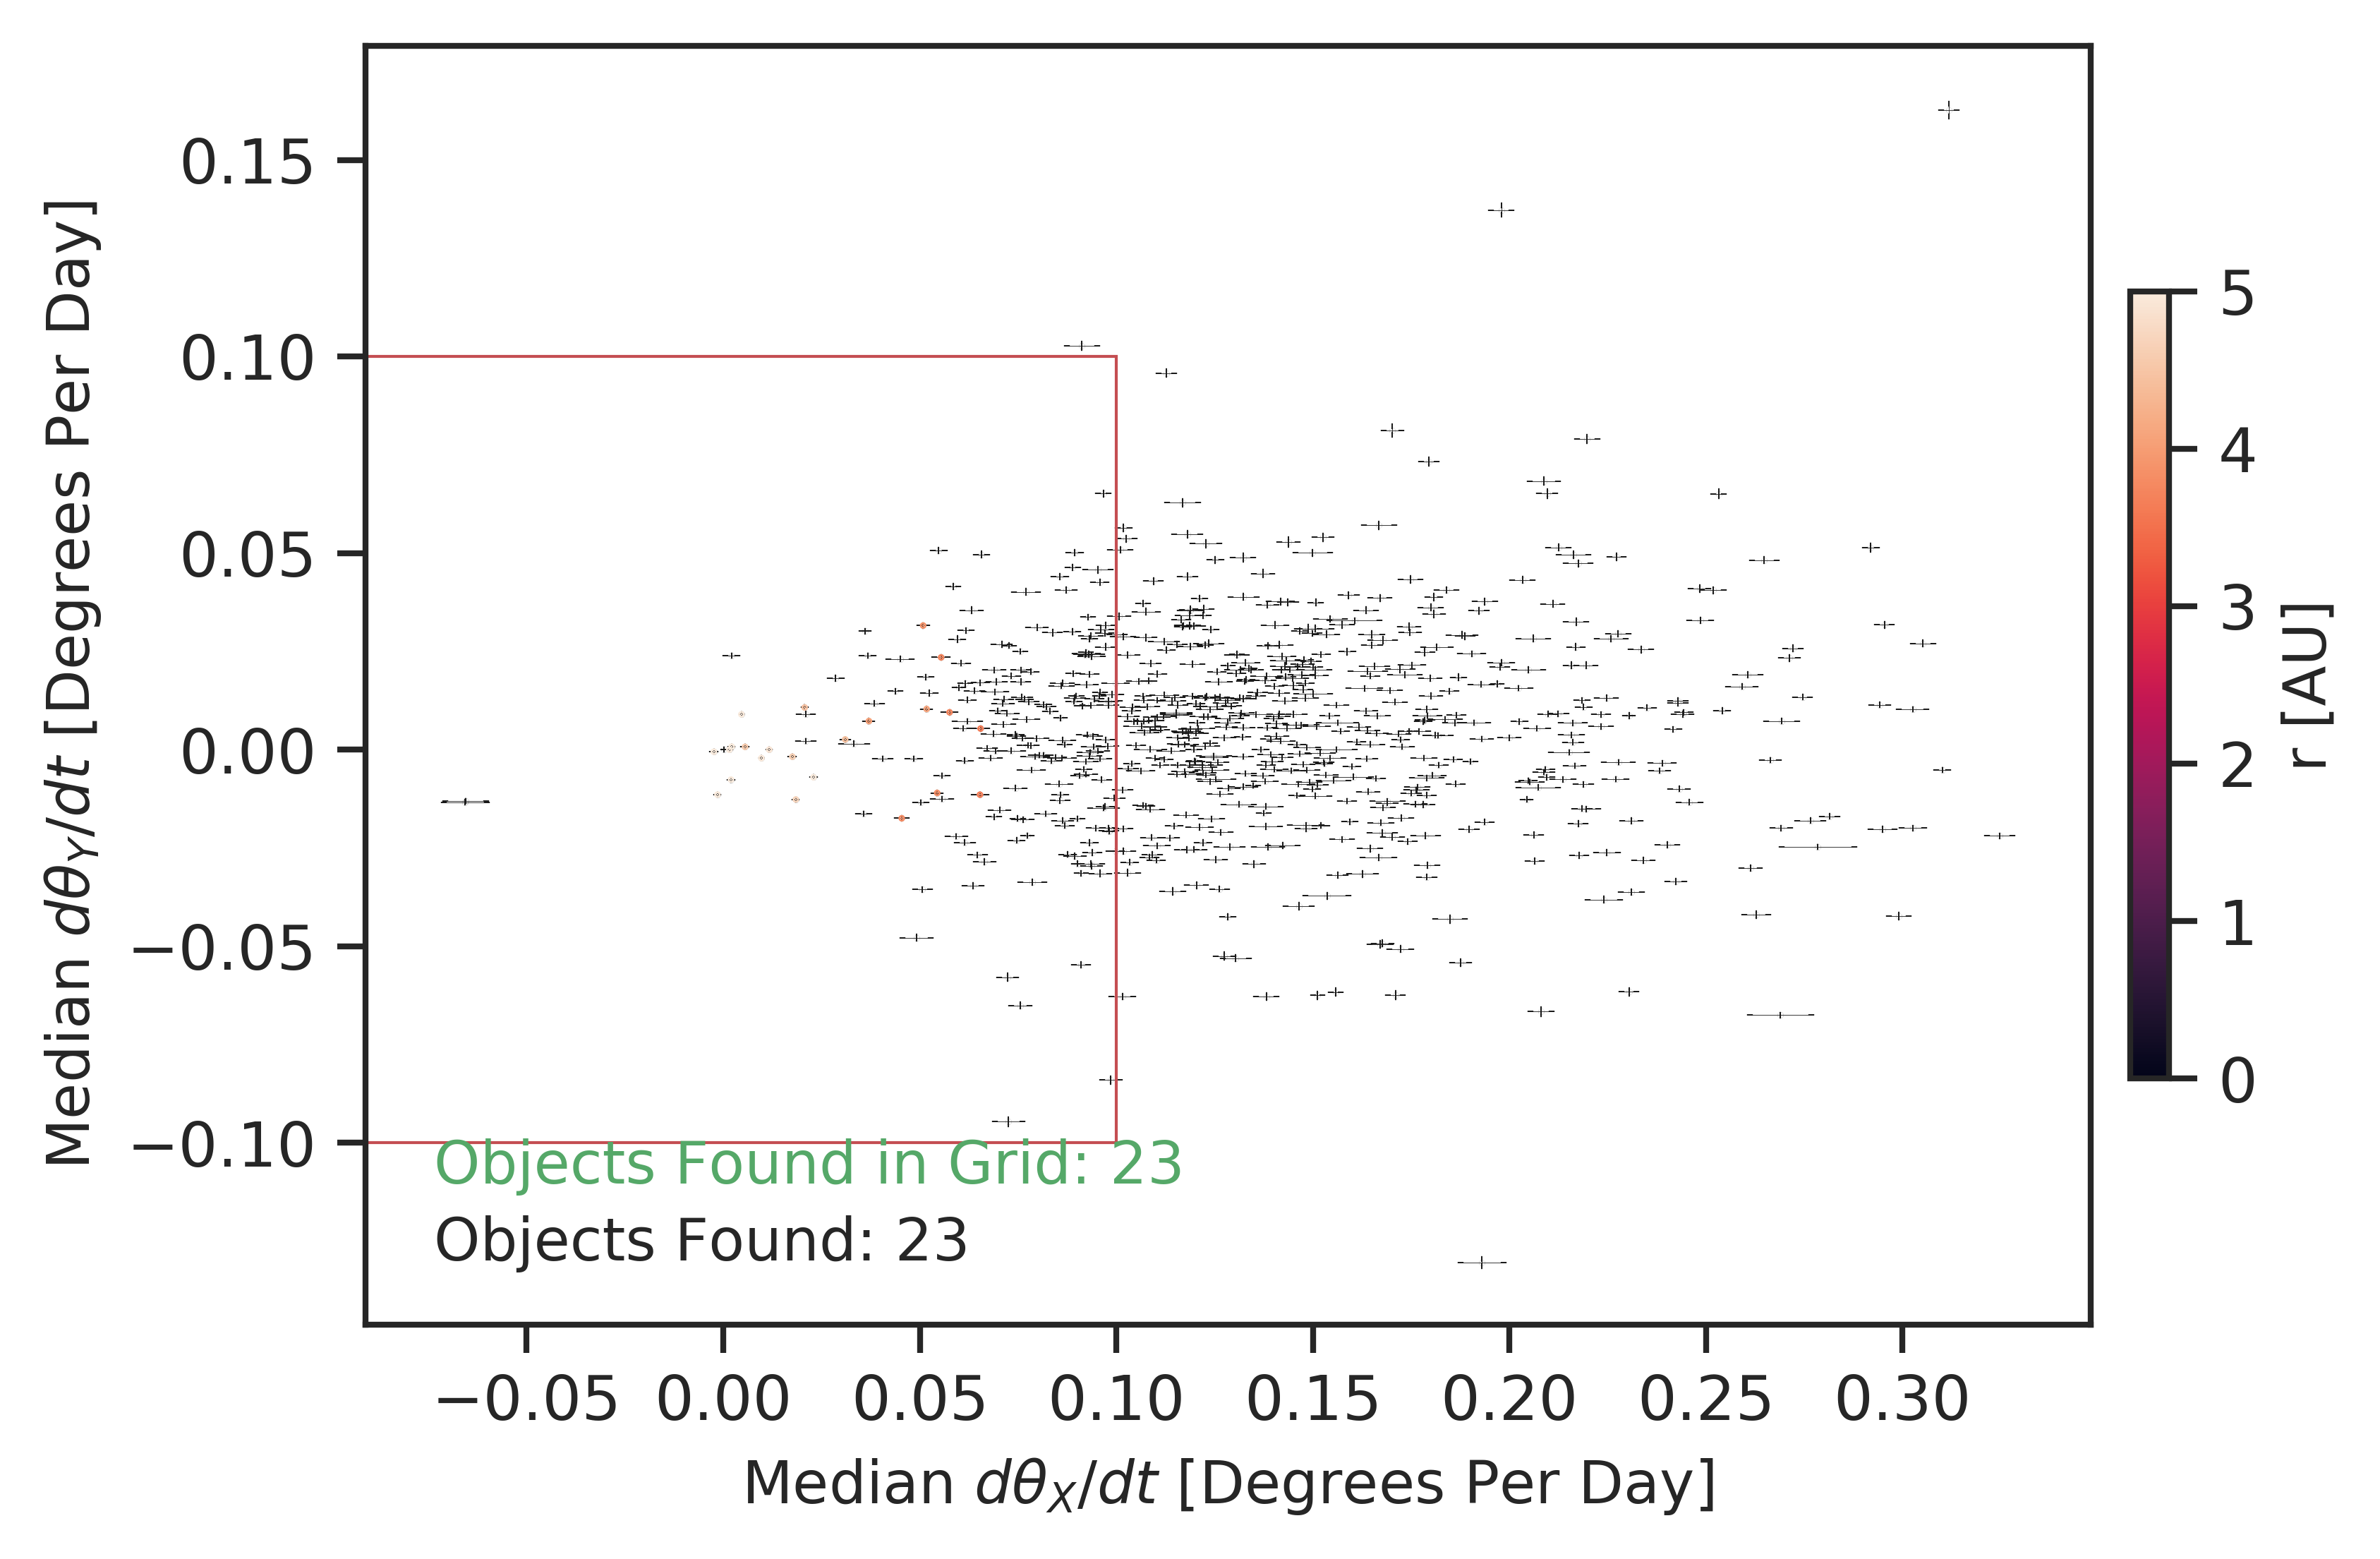

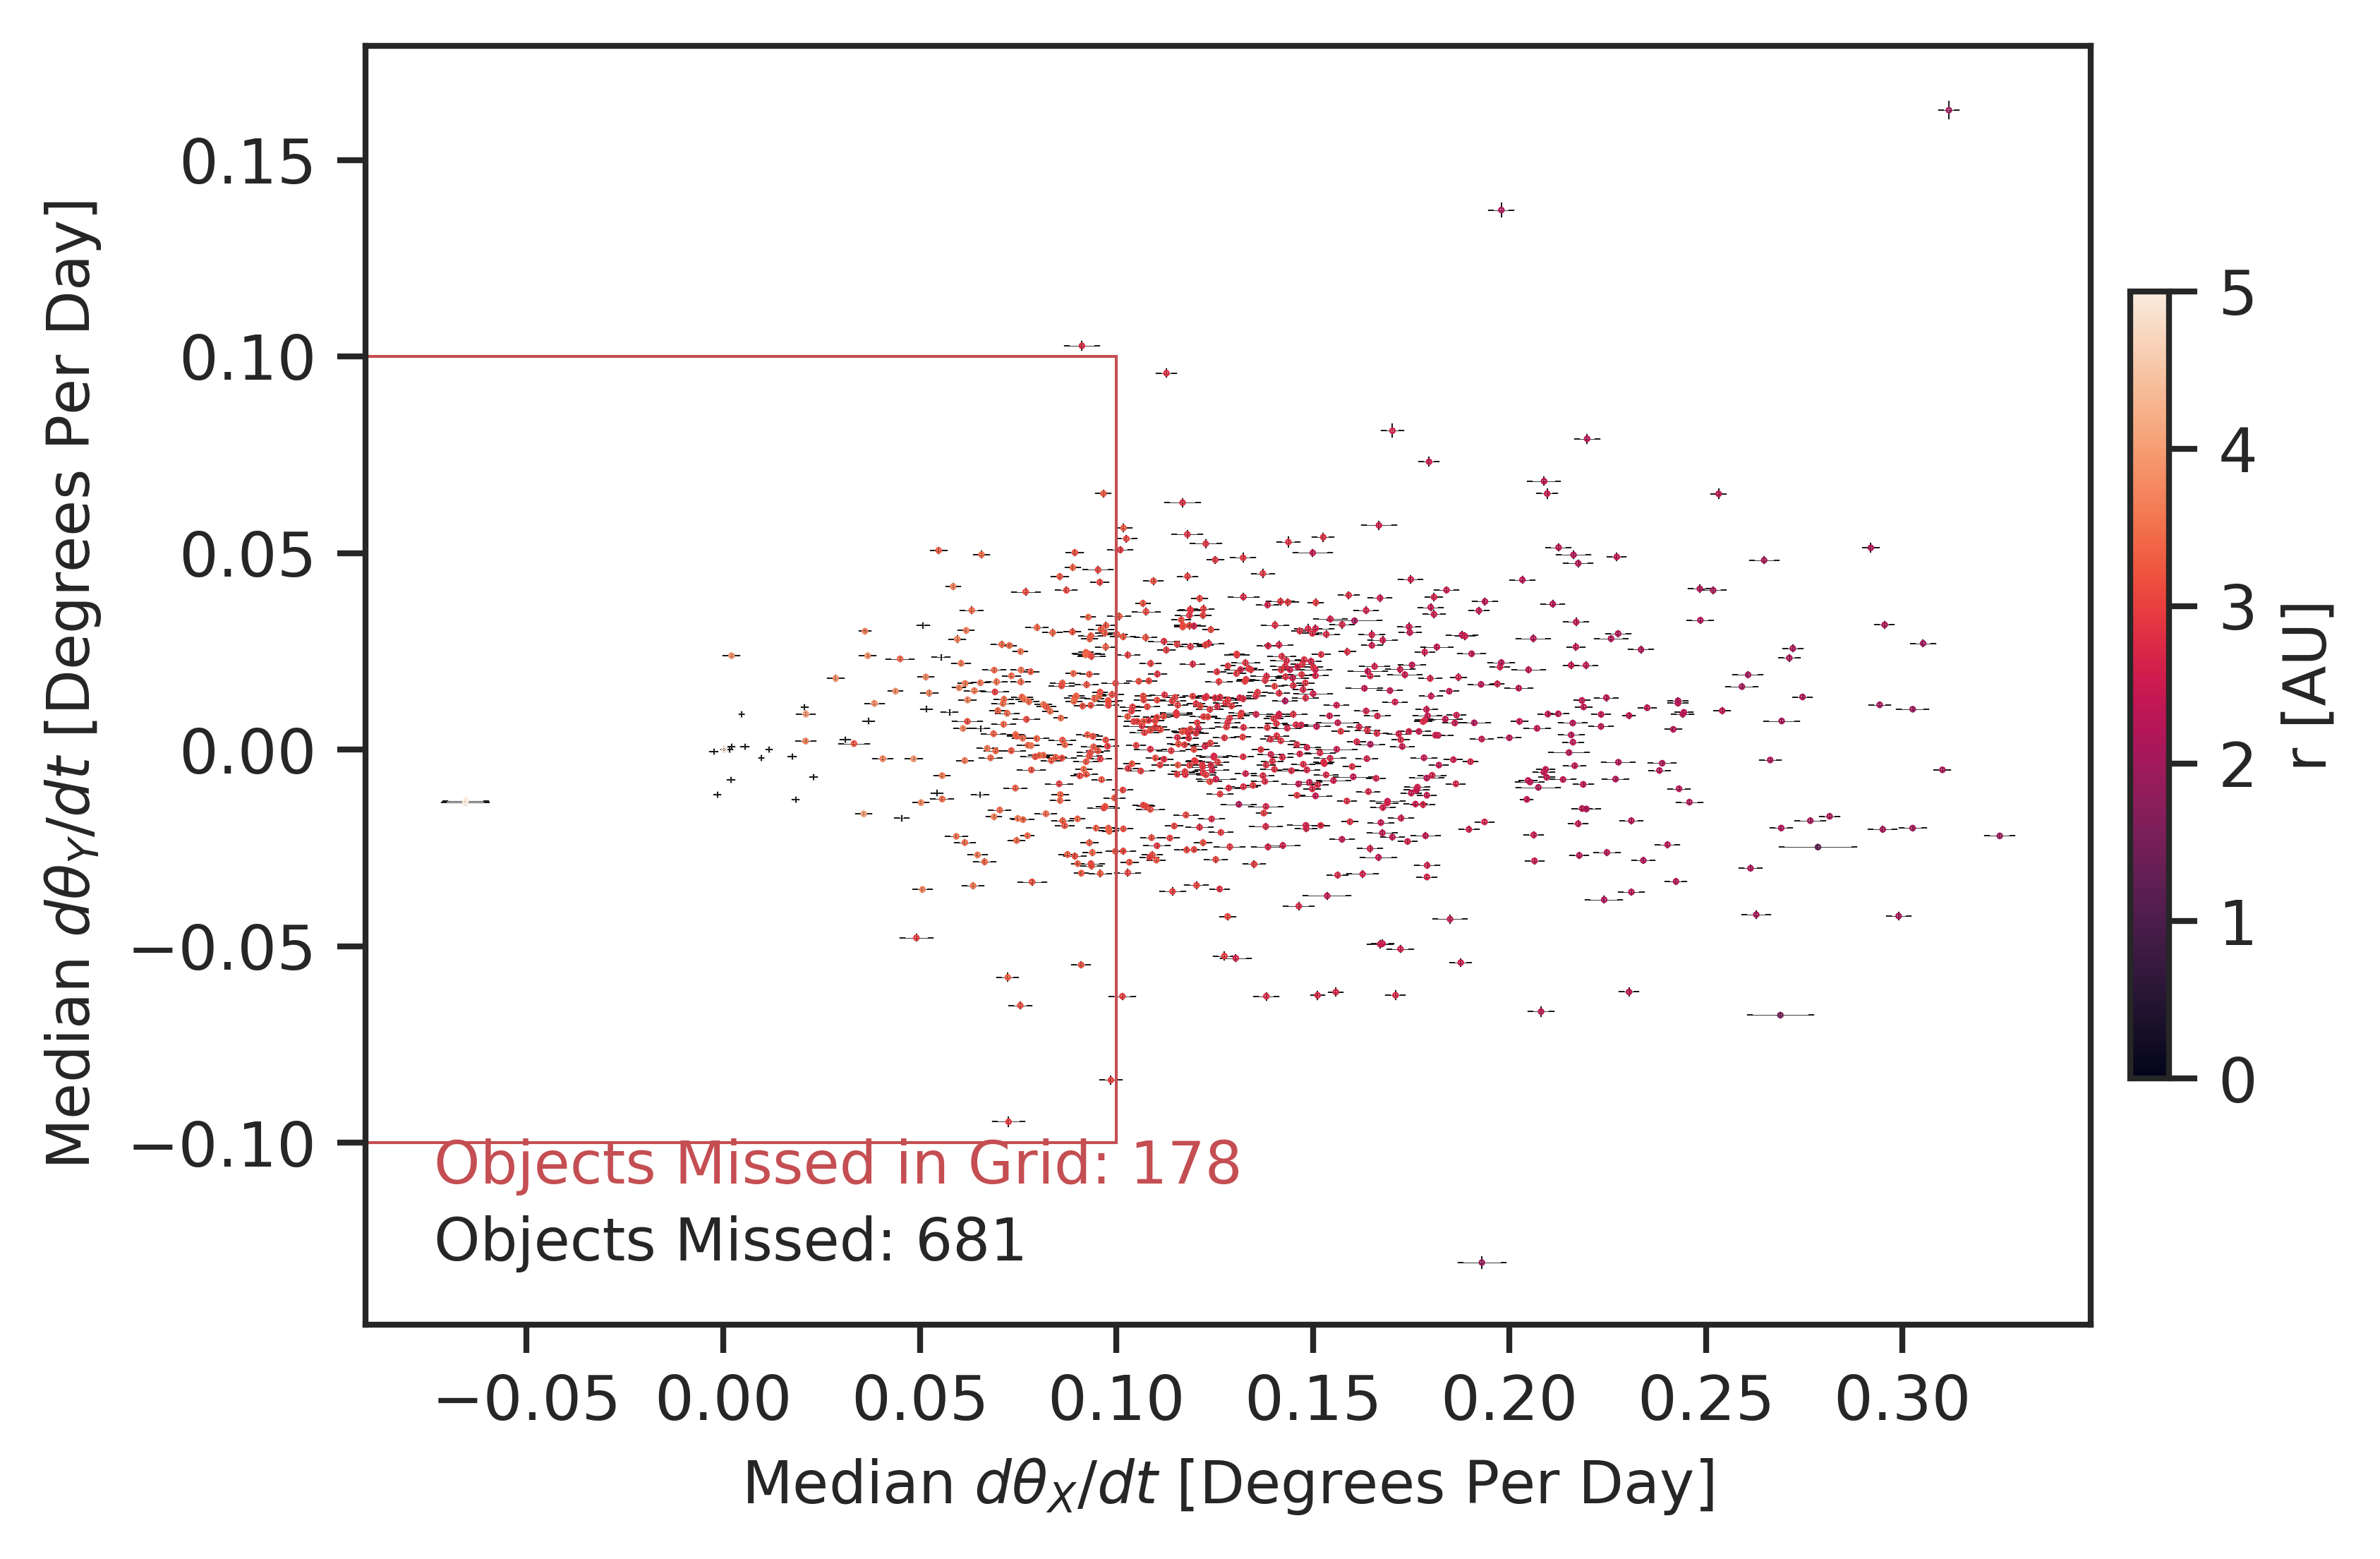

In [17]:
allObjects_survey, summary_survey, summaries_projection = thor.runTHOR(observations, average_orbits, runDir="test/")